In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

from tqdm import tqdm

import os
import argparse
import numpy as np
from copy import deepcopy

from models import *
from models.resnet import *
from utils.datasets import * 
from utils.utils import * 
import test

from terminaltables import AsciiTable

if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument('--model-name', type=str, default='VGG16', help='model name')
    parser.add_argument('--baseline-checkpoint', type=str, default='exp_VGG16/baseline/checkpoint/last.pth', help='baseline-checkpoint path')
    parser.add_argument('--sp-checkpoint', type=str, default='exp_VGG16/sp/checkpoint/last.pth', help='sp-checkpoint path')
    parser.add_argument('--saved-dir', type=str, default='exp_VGG16/l1-norm_ns_random', help='sensitivity saved directory')
    parser.add_argument('--layer-keep', type=float, default=0.01, help='channel keep percent per layer')
    parser.add_argument('--img-size', type=int, default=32, help='inference size (pixels)')

    opt = parser.parse_args(args=[])
#     opt = parser.parse_args()
    
    print(opt)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # get baseline model
    baseline_checkpoint = opt.baseline_checkpoint
    model_name = opt.model_name
    assert os.path.isfile(baseline_checkpoint), 'Error: no %s file found!'%baseline_checkpoint
    if baseline_checkpoint.endswith('.pth'): # only load weights from file
        baseline_model = globals()[opt.model_name]()
        baseline_model.load_state_dict(torch.load(baseline_checkpoint)['model'])
        baseline_model = baseline_model.to(device)
    else:
        assert False, "baseline_checkpoint is not end with '.pth'"
    
    # get sp model
    sp_checkpoint = opt.sp_checkpoint
    model_name = opt.model_name
    assert os.path.isfile(sp_checkpoint), 'Error: no %s file found!'%sp_checkpoint
    if sp_checkpoint.endswith('.pth'): # only load weights from file
        sp_model = globals()[opt.model_name]()
        sp_model.load_state_dict(torch.load(sp_checkpoint)['model'])
        sp_model = sp_model.to(device)
    else:
        assert False, "sp_checkpoint is not end with '.pth'"
    
    # test dataset
    batch_size = 128
    nw = min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8])  # number of workers
    testloader = cifar10_test_dataset(batch_size=batch_size, nw=nw)
    
    eval_model = lambda model:test.test(model=model, testloader=testloader)
    obtain_num_parameters = lambda model:sum([param.nelement() for param in model.parameters()])

    print("\nlet's test the baseline model:")
    baseline_model_metric = eval_model(baseline_model)
    baseline_nparameters = obtain_num_parameters(baseline_model)
    
    print("\nlet's test the sp model:")
    sp_model_metric = eval_model(sp_model)
    sp_nparameters = obtain_num_parameters(sp_model)
    

Namespace(baseline_checkpoint='exp_VGG16/baseline/checkpoint/last.pth', img_size=32, layer_keep=0.01, model_name='VGG16', saved_dir='exp_VGG16/l1-norm_ns_random', sp_checkpoint='exp_VGG16/sp/checkpoint/last.pth')
Files already downloaded and verified

let's test the baseline model:

 test_loss   correct     total       Acc


     0.294  9.37e+03     1e+04      93.7: 100%|██████████| 79/79 [00:01<00:00, 52.32it/s]



let's test the sp model:

 test_loss   correct     total       Acc


     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 73.36it/s]


In [2]:
    import random
    def shuffle(lis):
        result = []
        while lis:
            p = random.randrange(0, len(lis))
            result.append(lis[p])
            lis.pop(p)
        return result
    
    
    def get_sensitivity(model, percent_list, mode='ns'):
        # sensitivity ['module_idx', 'percent', 'real_percent', 'Acc', 'loss', 'mask']
        sen = []
        
        masked_model = deepcopy(model)

        origin_module_list = model.get_module_list()
        masked_module_list = masked_model.get_module_list()

        for m_idx,(m,origin_m) in enumerate(zip(masked_module_list,origin_module_list)):
            for percent in percent_list:
                num_filter = m['bn'].weight.data.shape[0]
                
                # 当前卷积模块最少要保留的输出通道数目
                min_channel_num = int(num_filter*opt.layer_keep) if int(num_filter * opt.layer_keep) > 0 else 1
                
                if mode == 'random':
                    mask = [1. if idx < min(int(num_filter*percent), min_channel_num) else 0. \
                            for idx in range(num_filter)]
                    mask = shuffle(mask)
                    
                    mask = torch.tensor(mask).to(device)
                elif mode == 'ns':
                    bn = m['bn'].weight.data.abs().clone()
                    
                    y,i = torch.sort(bn)
                    thre_index = int(num_filter*percent)
                    thre = y[thre_index]

                    mask = m['bn'].weight.data.abs().ge(thre)

                    # 当剪枝后输出通道数目小于当前卷积模块最少要保留的输出通道数目
                    if int(torch.sum(mask)) < min_channel_num: 
                        _, sorted_index_weights = torch.sort(weight_copy,descending=True)
                        mask[sorted_index_weights[:min_channel_num]]=1.
                elif mode == 'l1_norm':
                    conv = torch.sum(m['conv'].weight.data.abs().clone(),(1,2,3))
                    y,i = torch.sort(conv.clone())
                    thre_index = int(num_filter*percent)
                    thre = y[thre_index]
                    
                    mask = conv.ge(thre)
                    
                    # 当剪枝后输出通道数目小于当前卷积模块最少要保留的输出通道数目
                    if int(torch.sum(mask)) < min_channel_num: 
                        _, sorted_index_weights = torch.sort(conv,descending=True)
                        mask[sorted_index_weights[:min_channel_num]]=1.
                        
                if mode == "l1_norm":
                    for i,t in enumerate(mask):
                        if t == 0.:
                            m['conv'].weight.data[i].copy_(torch.zeros(m['conv'].weight.data[i].size()))
                else:
                    m['bn'].weight.data.mul_(mask)
                    m['bn'].bias.data.mul_(mask)

                remain = int(torch.sum(mask))
                pruned = num_filter - remain
                real_percent = pruned/num_filter

                print('\nmodule_idx:%3g, percent:%3g'%(m_idx, percent))
                metric = eval_model(masked_model)
                Acc = 100.*metric[1]/metric[2]
                loss = metric[0]

                sen.append([m_idx, percent, real_percent, Acc, loss, mask])
            
            if mode == 'l1_norm':
                m['conv'].weight.data.copy_(origin_m['conv'].weight.data)
            else:
                m['bn'].weight.data.copy_(origin_m['bn'].weight.data)
                m['bn'].bias.data.copy_(origin_m['bn'].bias.data)
    
        log = ('%10s'*5)%('module_idx', 'percent', 'real', 'Acc', 'loss')
        print(log)

        for s in sen:
            m_idx = s[0]
            percent = s[1]
            real = s[2]
            Acc = s[3]
            loss = s[4]

            log = ('%10.5g'*5)%(m_idx, percent, real, Acc, loss)
            print(log)
            
        return sen
    
    percent_list = [0., 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, \
                    0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95]
    l1_norm_sen = get_sensitivity(baseline_model, percent_list, 'l1_norm')
    ns_sen = get_sensitivity(sp_model, percent_list, 'ns')


module_idx:  0, percent:  0

 test_loss   correct     total       Acc


     0.294  9.37e+03     1e+04      93.7: 100%|██████████| 79/79 [00:01<00:00, 72.99it/s]


module_idx:  0, percent:0.05

 test_loss   correct     total       Acc



     0.294  9.37e+03     1e+04      93.7: 100%|██████████| 79/79 [00:01<00:00, 73.02it/s]



module_idx:  0, percent:0.1

 test_loss   correct     total       Acc


     0.294  9.37e+03     1e+04      93.7: 100%|██████████| 79/79 [00:01<00:00, 73.07it/s]



module_idx:  0, percent:0.15

 test_loss   correct     total       Acc


     0.294  9.37e+03     1e+04      93.7: 100%|██████████| 79/79 [00:01<00:00, 73.91it/s]



module_idx:  0, percent:0.2

 test_loss   correct     total       Acc


     0.294  9.37e+03     1e+04      93.7: 100%|██████████| 79/79 [00:01<00:00, 74.95it/s]



module_idx:  0, percent:0.25

 test_loss   correct     total       Acc


     0.294  9.37e+03     1e+04      93.7: 100%|██████████| 79/79 [00:01<00:00, 74.00it/s]



module_idx:  0, percent:0.3

 test_loss   correct     total       Acc


     0.294  9.37e+03     1e+04      93.7: 100%|██████████| 79/79 [00:01<00:00, 77.05it/s]



module_idx:  0, percent:0.35

 test_loss   correct     total       Acc


     0.294  9.37e+03     1e+04      93.7: 100%|██████████| 79/79 [00:01<00:00, 72.42it/s]



module_idx:  0, percent:0.4

 test_loss   correct     total       Acc


     0.294  9.37e+03     1e+04      93.7: 100%|██████████| 79/79 [00:01<00:00, 73.01it/s]



module_idx:  0, percent:0.45

 test_loss   correct     total       Acc


     0.294  9.37e+03     1e+04      93.7: 100%|██████████| 79/79 [00:01<00:00, 72.27it/s]



module_idx:  0, percent:0.5

 test_loss   correct     total       Acc


     0.294  9.37e+03     1e+04      93.7: 100%|██████████| 79/79 [00:01<00:00, 74.60it/s]



module_idx:  0, percent:0.55

 test_loss   correct     total       Acc


     0.294  9.37e+03     1e+04      93.7: 100%|██████████| 79/79 [00:01<00:00, 73.01it/s]



module_idx:  0, percent:0.6

 test_loss   correct     total       Acc


     0.294  9.37e+03     1e+04      93.7: 100%|██████████| 79/79 [00:01<00:00, 73.22it/s]



module_idx:  0, percent:0.65

 test_loss   correct     total       Acc


     0.324  9.33e+03     1e+04      93.3: 100%|██████████| 79/79 [00:01<00:00, 72.53it/s]



module_idx:  0, percent:0.7

 test_loss   correct     total       Acc


     0.329   9.3e+03     1e+04        93: 100%|██████████| 79/79 [00:01<00:00, 71.67it/s]



module_idx:  0, percent:0.75

 test_loss   correct     total       Acc


     0.355  9.27e+03     1e+04      92.7: 100%|██████████| 79/79 [00:01<00:00, 72.49it/s]



module_idx:  0, percent:0.8

 test_loss   correct     total       Acc


     0.386  9.21e+03     1e+04      92.1: 100%|██████████| 79/79 [00:01<00:00, 71.72it/s]



module_idx:  0, percent:0.85

 test_loss   correct     total       Acc


     0.468  9.05e+03     1e+04      90.5: 100%|██████████| 79/79 [00:01<00:00, 71.78it/s]



module_idx:  0, percent:0.9

 test_loss   correct     total       Acc


      1.14  7.83e+03     1e+04      78.3: 100%|██████████| 79/79 [00:01<00:00, 72.19it/s]



module_idx:  0, percent:0.95

 test_loss   correct     total       Acc


      2.11  5.91e+03     1e+04      59.1: 100%|██████████| 79/79 [00:01<00:00, 75.38it/s]



module_idx:  1, percent:  0

 test_loss   correct     total       Acc


     0.294  9.37e+03     1e+04      93.7: 100%|██████████| 79/79 [00:01<00:00, 72.82it/s]



module_idx:  1, percent:0.05

 test_loss   correct     total       Acc


     0.297  9.36e+03     1e+04      93.7: 100%|██████████| 79/79 [00:01<00:00, 74.72it/s]



module_idx:  1, percent:0.1

 test_loss   correct     total       Acc


     0.309  9.35e+03     1e+04      93.5: 100%|██████████| 79/79 [00:01<00:00, 72.25it/s]



module_idx:  1, percent:0.15

 test_loss   correct     total       Acc


     0.333   9.3e+03     1e+04        93: 100%|██████████| 79/79 [00:01<00:00, 73.14it/s]



module_idx:  1, percent:0.2

 test_loss   correct     total       Acc


     0.357  9.25e+03     1e+04      92.5: 100%|██████████| 79/79 [00:01<00:00, 73.91it/s]



module_idx:  1, percent:0.25

 test_loss   correct     total       Acc


     0.401  9.18e+03     1e+04      91.8: 100%|██████████| 79/79 [00:01<00:00, 74.36it/s]



module_idx:  1, percent:0.3

 test_loss   correct     total       Acc


     0.525  8.95e+03     1e+04      89.5: 100%|██████████| 79/79 [00:01<00:00, 72.73it/s]



module_idx:  1, percent:0.35

 test_loss   correct     total       Acc


     0.639  8.69e+03     1e+04      86.9: 100%|██████████| 79/79 [00:01<00:00, 72.55it/s]



module_idx:  1, percent:0.4

 test_loss   correct     total       Acc


     0.654  8.65e+03     1e+04      86.5: 100%|██████████| 79/79 [00:01<00:00, 72.17it/s]



module_idx:  1, percent:0.45

 test_loss   correct     total       Acc


     0.715  8.53e+03     1e+04      85.3: 100%|██████████| 79/79 [00:01<00:00, 71.69it/s]



module_idx:  1, percent:0.5

 test_loss   correct     total       Acc


      1.07  7.87e+03     1e+04      78.7: 100%|██████████| 79/79 [00:01<00:00, 74.76it/s]



module_idx:  1, percent:0.55

 test_loss   correct     total       Acc


      1.56  7.03e+03     1e+04      70.3: 100%|██████████| 79/79 [00:01<00:00, 76.70it/s]



module_idx:  1, percent:0.6

 test_loss   correct     total       Acc


       1.7  6.82e+03     1e+04      68.2: 100%|██████████| 79/79 [00:01<00:00, 72.14it/s]



module_idx:  1, percent:0.65

 test_loss   correct     total       Acc


      2.87  5.29e+03     1e+04      52.9: 100%|██████████| 79/79 [00:01<00:00, 72.79it/s]



module_idx:  1, percent:0.7

 test_loss   correct     total       Acc


      3.46  4.51e+03     1e+04      45.1: 100%|██████████| 79/79 [00:01<00:00, 73.95it/s]


module_idx:  1, percent:0.75

 test_loss   correct     total       Acc



      4.26   3.3e+03     1e+04        33: 100%|██████████| 79/79 [00:01<00:00, 74.24it/s]



module_idx:  1, percent:0.8

 test_loss   correct     total       Acc


      4.55  2.42e+03     1e+04      24.2: 100%|██████████| 79/79 [00:01<00:00, 71.66it/s]



module_idx:  1, percent:0.85

 test_loss   correct     total       Acc


      4.43  1.94e+03     1e+04      19.4: 100%|██████████| 79/79 [00:01<00:00, 76.58it/s]



module_idx:  1, percent:0.9

 test_loss   correct     total       Acc


      3.86  1.49e+03     1e+04      14.9: 100%|██████████| 79/79 [00:01<00:00, 74.64it/s]



module_idx:  1, percent:0.95

 test_loss   correct     total       Acc


      4.07  1.42e+03     1e+04      14.2: 100%|██████████| 79/79 [00:01<00:00, 72.74it/s]



module_idx:  2, percent:  0

 test_loss   correct     total       Acc


     0.294  9.37e+03     1e+04      93.7: 100%|██████████| 79/79 [00:01<00:00, 72.10it/s]



module_idx:  2, percent:0.05

 test_loss   correct     total       Acc


     0.296  9.38e+03     1e+04      93.8: 100%|██████████| 79/79 [00:01<00:00, 71.01it/s]



module_idx:  2, percent:0.1

 test_loss   correct     total       Acc


     0.304  9.37e+03     1e+04      93.7: 100%|██████████| 79/79 [00:01<00:00, 73.14it/s]



module_idx:  2, percent:0.15

 test_loss   correct     total       Acc


     0.314  9.36e+03     1e+04      93.5: 100%|██████████| 79/79 [00:01<00:00, 72.21it/s]



module_idx:  2, percent:0.2

 test_loss   correct     total       Acc


     0.325  9.34e+03     1e+04      93.4: 100%|██████████| 79/79 [00:01<00:00, 74.01it/s]



module_idx:  2, percent:0.25

 test_loss   correct     total       Acc


     0.408  9.17e+03     1e+04      91.7: 100%|██████████| 79/79 [00:01<00:00, 75.55it/s]



module_idx:  2, percent:0.3

 test_loss   correct     total       Acc


     0.437  9.10e+03     1e+04        91: 100%|██████████| 79/79 [00:01<00:00, 73.85it/s]



module_idx:  2, percent:0.35

 test_loss   correct     total       Acc


     0.541  8.94e+03     1e+04      89.4: 100%|██████████| 79/79 [00:01<00:00, 72.13it/s]



module_idx:  2, percent:0.4

 test_loss   correct     total       Acc


     0.672   8.7e+03     1e+04        87: 100%|██████████| 79/79 [00:01<00:00, 72.84it/s]



module_idx:  2, percent:0.45

 test_loss   correct     total       Acc


     0.811  8.43e+03     1e+04      84.3: 100%|██████████| 79/79 [00:01<00:00, 74.22it/s]



module_idx:  2, percent:0.5

 test_loss   correct     total       Acc


     0.985  8.11e+03     1e+04      81.1: 100%|██████████| 79/79 [00:01<00:00, 73.07it/s]



module_idx:  2, percent:0.55

 test_loss   correct     total       Acc


      1.45  7.29e+03     1e+04      72.9: 100%|██████████| 79/79 [00:01<00:00, 67.95it/s]



module_idx:  2, percent:0.6

 test_loss   correct     total       Acc


      2.25  6.09e+03     1e+04      60.9: 100%|██████████| 79/79 [00:01<00:00, 72.54it/s]



module_idx:  2, percent:0.65

 test_loss   correct     total       Acc


      3.89  3.95e+03     1e+04      39.5: 100%|██████████| 79/79 [00:01<00:00, 73.07it/s]



module_idx:  2, percent:0.7

 test_loss   correct     total       Acc


      3.97  3.73e+03     1e+04      37.3: 100%|██████████| 79/79 [00:01<00:00, 75.40it/s]



module_idx:  2, percent:0.75

 test_loss   correct     total       Acc


      4.95  2.59e+03     1e+04      25.9: 100%|██████████| 79/79 [00:01<00:00, 71.87it/s]



module_idx:  2, percent:0.8

 test_loss   correct     total       Acc


      5.67  1.79e+03     1e+04      17.9: 100%|██████████| 79/79 [00:01<00:00, 75.22it/s]



module_idx:  2, percent:0.85

 test_loss   correct     total       Acc


      5.67  1.31e+03     1e+04      13.1: 100%|██████████| 79/79 [00:01<00:00, 75.30it/s]



module_idx:  2, percent:0.9

 test_loss   correct     total       Acc


      5.09  1.09e+03     1e+04      10.9: 100%|██████████| 79/79 [00:01<00:00, 72.20it/s]



module_idx:  2, percent:0.95

 test_loss   correct     total       Acc


      4.82  1.11e+03     1e+04      11.1: 100%|██████████| 79/79 [00:01<00:00, 72.61it/s]



module_idx:  3, percent:  0

 test_loss   correct     total       Acc


     0.294  9.37e+03     1e+04      93.7: 100%|██████████| 79/79 [00:01<00:00, 73.95it/s]



module_idx:  3, percent:0.05

 test_loss   correct     total       Acc


     0.315  9.34e+03     1e+04      93.4: 100%|██████████| 79/79 [00:01<00:00, 71.15it/s]



module_idx:  3, percent:0.1

 test_loss   correct     total       Acc


     0.334   9.3e+03     1e+04        93: 100%|██████████| 79/79 [00:01<00:00, 71.54it/s]



module_idx:  3, percent:0.15

 test_loss   correct     total       Acc


     0.358  9.27e+03     1e+04      92.7: 100%|██████████| 79/79 [00:01<00:00, 72.00it/s]



module_idx:  3, percent:0.2

 test_loss   correct     total       Acc


     0.432  9.11e+03     1e+04      91.1: 100%|██████████| 79/79 [00:01<00:00, 71.22it/s]



module_idx:  3, percent:0.25

 test_loss   correct     total       Acc


     0.493  8.96e+03     1e+04      89.7: 100%|██████████| 79/79 [00:01<00:00, 72.39it/s]



module_idx:  3, percent:0.3

 test_loss   correct     total       Acc


     0.665  8.65e+03     1e+04      86.5: 100%|██████████| 79/79 [00:01<00:00, 72.34it/s]



module_idx:  3, percent:0.35

 test_loss   correct     total       Acc


     0.724   8.5e+03     1e+04        85: 100%|██████████| 79/79 [00:01<00:00, 71.83it/s]



module_idx:  3, percent:0.4

 test_loss   correct     total       Acc


     0.839  8.33e+03     1e+04      83.3: 100%|██████████| 79/79 [00:01<00:00, 72.43it/s]



module_idx:  3, percent:0.45

 test_loss   correct     total       Acc


         1  7.89e+03     1e+04      78.9: 100%|██████████| 79/79 [00:01<00:00, 74.16it/s]



module_idx:  3, percent:0.5

 test_loss   correct     total       Acc


      1.81  6.31e+03     1e+04      63.1: 100%|██████████| 79/79 [00:01<00:00, 72.37it/s]



module_idx:  3, percent:0.55

 test_loss   correct     total       Acc


      2.94   4.6e+03     1e+04        46: 100%|██████████| 79/79 [00:01<00:00, 73.48it/s]



module_idx:  3, percent:0.6

 test_loss   correct     total       Acc


      3.93  3.35e+03     1e+04      33.5: 100%|██████████| 79/79 [00:01<00:00, 74.30it/s]



module_idx:  3, percent:0.65

 test_loss   correct     total       Acc


      4.29  2.81e+03     1e+04      28.1: 100%|██████████| 79/79 [00:01<00:00, 77.60it/s]



module_idx:  3, percent:0.7

 test_loss   correct     total       Acc


      4.66  2.17e+03     1e+04      21.7: 100%|██████████| 79/79 [00:01<00:00, 75.09it/s]



module_idx:  3, percent:0.75

 test_loss   correct     total       Acc


      5.76  1.39e+03     1e+04      13.9: 100%|██████████| 79/79 [00:01<00:00, 72.81it/s]



module_idx:  3, percent:0.8

 test_loss   correct     total       Acc


      5.93  1.15e+03     1e+04      11.5: 100%|██████████| 79/79 [00:01<00:00, 71.69it/s]



module_idx:  3, percent:0.85

 test_loss   correct     total       Acc


      6.92     1e+03     1e+04        10: 100%|██████████| 79/79 [00:01<00:00, 70.23it/s]



module_idx:  3, percent:0.9

 test_loss   correct     total       Acc


      6.35     1e+03     1e+04        10: 100%|██████████| 79/79 [00:01<00:00, 72.58it/s]



module_idx:  3, percent:0.95

 test_loss   correct     total       Acc


      5.27     1e+03     1e+04        10: 100%|██████████| 79/79 [00:01<00:00, 72.10it/s]



module_idx:  4, percent:  0

 test_loss   correct     total       Acc


     0.294  9.37e+03     1e+04      93.7: 100%|██████████| 79/79 [00:01<00:00, 71.60it/s]



module_idx:  4, percent:0.05

 test_loss   correct     total       Acc


       0.3  9.38e+03     1e+04      93.8: 100%|██████████| 79/79 [00:01<00:00, 70.77it/s]



module_idx:  4, percent:0.1

 test_loss   correct     total       Acc


     0.327  9.29e+03     1e+04      92.9: 100%|██████████| 79/79 [00:01<00:00, 71.53it/s]



module_idx:  4, percent:0.15

 test_loss   correct     total       Acc


     0.351  9.24e+03     1e+04      92.4: 100%|██████████| 79/79 [00:01<00:00, 72.42it/s]



module_idx:  4, percent:0.2

 test_loss   correct     total       Acc


     0.425  9.08e+03     1e+04      90.8: 100%|██████████| 79/79 [00:01<00:00, 71.03it/s]



module_idx:  4, percent:0.25

 test_loss   correct     total       Acc


     0.742  8.51e+03     1e+04      85.1: 100%|██████████| 79/79 [00:01<00:00, 71.29it/s]



module_idx:  4, percent:0.3

 test_loss   correct     total       Acc


      1.11  7.84e+03     1e+04      78.4: 100%|██████████| 79/79 [00:01<00:00, 71.41it/s]



module_idx:  4, percent:0.35

 test_loss   correct     total       Acc


      1.58  6.79e+03     1e+04      67.9: 100%|██████████| 79/79 [00:01<00:00, 72.40it/s]



module_idx:  4, percent:0.4

 test_loss   correct     total       Acc


      2.12  5.74e+03     1e+04      57.4: 100%|██████████| 79/79 [00:01<00:00, 71.56it/s]



module_idx:  4, percent:0.45

 test_loss   correct     total       Acc


      2.78  4.59e+03     1e+04      45.9: 100%|██████████| 79/79 [00:01<00:00, 72.21it/s]



module_idx:  4, percent:0.5

 test_loss   correct     total       Acc


      3.25  3.14e+03     1e+04      31.4: 100%|██████████| 79/79 [00:01<00:00, 71.87it/s]



module_idx:  4, percent:0.55

 test_loss   correct     total       Acc


      3.63  2.26e+03     1e+04      22.6: 100%|██████████| 79/79 [00:01<00:00, 70.77it/s]



module_idx:  4, percent:0.6

 test_loss   correct     total       Acc


      3.78  1.95e+03     1e+04      19.5: 100%|██████████| 79/79 [00:01<00:00, 72.96it/s]



module_idx:  4, percent:0.65

 test_loss   correct     total       Acc


      3.98  1.37e+03     1e+04      13.7: 100%|██████████| 79/79 [00:01<00:00, 71.45it/s]



module_idx:  4, percent:0.7

 test_loss   correct     total       Acc


      3.78  1.26e+03     1e+04      12.6: 100%|██████████| 79/79 [00:01<00:00, 71.91it/s]



module_idx:  4, percent:0.75

 test_loss   correct     total       Acc


      3.68  1.22e+03     1e+04      12.2: 100%|██████████| 79/79 [00:01<00:00, 70.75it/s]



module_idx:  4, percent:0.8

 test_loss   correct     total       Acc


      3.55  1.32e+03     1e+04      13.2: 100%|██████████| 79/79 [00:01<00:00, 73.45it/s]



module_idx:  4, percent:0.85

 test_loss   correct     total       Acc


      4.61     1e+03     1e+04        10: 100%|██████████| 79/79 [00:01<00:00, 73.96it/s]



module_idx:  4, percent:0.9

 test_loss   correct     total       Acc


      4.37     1e+03     1e+04        10: 100%|██████████| 79/79 [00:01<00:00, 73.48it/s]



module_idx:  4, percent:0.95

 test_loss   correct     total       Acc


      4.42       999     1e+04      9.99: 100%|██████████| 79/79 [00:01<00:00, 73.79it/s]



module_idx:  5, percent:  0

 test_loss   correct     total       Acc


     0.294  9.37e+03     1e+04      93.7: 100%|██████████| 79/79 [00:01<00:00, 72.71it/s]



module_idx:  5, percent:0.05

 test_loss   correct     total       Acc


     0.312  9.34e+03     1e+04      93.4: 100%|██████████| 79/79 [00:01<00:00, 72.84it/s]



module_idx:  5, percent:0.1

 test_loss   correct     total       Acc


     0.326  9.32e+03     1e+04      93.2: 100%|██████████| 79/79 [00:01<00:00, 74.40it/s]



module_idx:  5, percent:0.15

 test_loss   correct     total       Acc


     0.339  9.25e+03     1e+04      92.5: 100%|██████████| 79/79 [00:01<00:00, 75.10it/s]



module_idx:  5, percent:0.2

 test_loss   correct     total       Acc


     0.338  9.25e+03     1e+04      92.5: 100%|██████████| 79/79 [00:01<00:00, 73.84it/s]



module_idx:  5, percent:0.25

 test_loss   correct     total       Acc


     0.401  9.12e+03     1e+04      91.2: 100%|██████████| 79/79 [00:01<00:00, 71.47it/s]



module_idx:  5, percent:0.3

 test_loss   correct     total       Acc


     0.451  8.97e+03     1e+04      89.7: 100%|██████████| 79/79 [00:01<00:00, 72.84it/s]



module_idx:  5, percent:0.35

 test_loss   correct     total       Acc


     0.474  8.86e+03     1e+04      88.6: 100%|██████████| 79/79 [00:01<00:00, 74.53it/s]



module_idx:  5, percent:0.4

 test_loss   correct     total       Acc


     0.599   8.5e+03     1e+04        85: 100%|██████████| 79/79 [00:01<00:00, 72.29it/s]



module_idx:  5, percent:0.45

 test_loss   correct     total       Acc


     0.655  8.27e+03     1e+04      82.7: 100%|██████████| 79/79 [00:01<00:00, 74.36it/s]



module_idx:  5, percent:0.5

 test_loss   correct     total       Acc


      0.76  8.01e+03     1e+04      80.1: 100%|██████████| 79/79 [00:01<00:00, 72.96it/s]



module_idx:  5, percent:0.55

 test_loss   correct     total       Acc


      1.46  6.15e+03     1e+04      61.5: 100%|██████████| 79/79 [00:01<00:00, 71.84it/s]



module_idx:  5, percent:0.6

 test_loss   correct     total       Acc


      1.57  5.84e+03     1e+04      58.4: 100%|██████████| 79/79 [00:01<00:00, 73.19it/s]



module_idx:  5, percent:0.65

 test_loss   correct     total       Acc


      2.76  3.84e+03     1e+04      38.4: 100%|██████████| 79/79 [00:01<00:00, 72.76it/s]



module_idx:  5, percent:0.7

 test_loss   correct     total       Acc


      3.01  3.47e+03     1e+04      34.7: 100%|██████████| 79/79 [00:01<00:00, 72.50it/s]



module_idx:  5, percent:0.75

 test_loss   correct     total       Acc


      3.25  3.14e+03     1e+04      31.4: 100%|██████████| 79/79 [00:01<00:00, 75.12it/s]



module_idx:  5, percent:0.8

 test_loss   correct     total       Acc


      3.68   2.7e+03     1e+04        27: 100%|██████████| 79/79 [00:01<00:00, 72.86it/s]



module_idx:  5, percent:0.85

 test_loss   correct     total       Acc


       4.9  1.23e+03     1e+04      12.3: 100%|██████████| 79/79 [00:01<00:00, 72.23it/s]



module_idx:  5, percent:0.9

 test_loss   correct     total       Acc


      4.45  1.49e+03     1e+04      14.9: 100%|██████████| 79/79 [00:01<00:00, 73.20it/s]



module_idx:  5, percent:0.95

 test_loss   correct     total       Acc


      5.86  1.02e+03     1e+04      10.2: 100%|██████████| 79/79 [00:01<00:00, 71.28it/s]



module_idx:  6, percent:  0

 test_loss   correct     total       Acc


     0.294  9.37e+03     1e+04      93.7: 100%|██████████| 79/79 [00:01<00:00, 72.42it/s]



module_idx:  6, percent:0.05

 test_loss   correct     total       Acc


     0.298  9.37e+03     1e+04      93.7: 100%|██████████| 79/79 [00:01<00:00, 76.39it/s]



module_idx:  6, percent:0.1

 test_loss   correct     total       Acc


     0.302  9.36e+03     1e+04      93.6: 100%|██████████| 79/79 [00:01<00:00, 71.60it/s]



module_idx:  6, percent:0.15

 test_loss   correct     total       Acc


     0.312  9.36e+03     1e+04      93.6: 100%|██████████| 79/79 [00:01<00:00, 73.20it/s]



module_idx:  6, percent:0.2

 test_loss   correct     total       Acc


     0.324  9.33e+03     1e+04      93.3: 100%|██████████| 79/79 [00:01<00:00, 76.23it/s]



module_idx:  6, percent:0.25

 test_loss   correct     total       Acc


     0.334   9.3e+03     1e+04        93: 100%|██████████| 79/79 [00:01<00:00, 71.15it/s]



module_idx:  6, percent:0.3

 test_loss   correct     total       Acc


     0.362  9.25e+03     1e+04      92.5: 100%|██████████| 79/79 [00:01<00:00, 72.46it/s]



module_idx:  6, percent:0.35

 test_loss   correct     total       Acc


     0.379  9.19e+03     1e+04      91.9: 100%|██████████| 79/79 [00:01<00:00, 74.83it/s]



module_idx:  6, percent:0.4

 test_loss   correct     total       Acc


     0.427  9.08e+03     1e+04      90.8: 100%|██████████| 79/79 [00:01<00:00, 72.13it/s]



module_idx:  6, percent:0.45

 test_loss   correct     total       Acc


     0.513  8.86e+03     1e+04      88.6: 100%|██████████| 79/79 [00:01<00:00, 72.62it/s]



module_idx:  6, percent:0.5

 test_loss   correct     total       Acc


     0.638  8.59e+03     1e+04      85.9: 100%|██████████| 79/79 [00:01<00:00, 71.73it/s]



module_idx:  6, percent:0.55

 test_loss   correct     total       Acc


     0.891  7.99e+03     1e+04      79.9: 100%|██████████| 79/79 [00:01<00:00, 71.48it/s]



module_idx:  6, percent:0.6

 test_loss   correct     total       Acc


      1.22   7.4e+03     1e+04        74: 100%|██████████| 79/79 [00:01<00:00, 71.57it/s]



module_idx:  6, percent:0.65

 test_loss   correct     total       Acc


       1.6  6.87e+03     1e+04      68.7: 100%|██████████| 79/79 [00:01<00:00, 74.80it/s]



module_idx:  6, percent:0.7

 test_loss   correct     total       Acc


      1.76  6.59e+03     1e+04      65.9: 100%|██████████| 79/79 [00:01<00:00, 73.92it/s]



module_idx:  6, percent:0.75

 test_loss   correct     total       Acc


       1.8  6.39e+03     1e+04      63.9: 100%|██████████| 79/79 [00:01<00:00, 76.34it/s]



module_idx:  6, percent:0.8

 test_loss   correct     total       Acc


      2.05  5.92e+03     1e+04      59.2: 100%|██████████| 79/79 [00:01<00:00, 74.03it/s]



module_idx:  6, percent:0.85

 test_loss   correct     total       Acc


      2.15  5.49e+03     1e+04      54.9: 100%|██████████| 79/79 [00:01<00:00, 73.73it/s]



module_idx:  6, percent:0.9

 test_loss   correct     total       Acc


      2.42  4.86e+03     1e+04      48.6: 100%|██████████| 79/79 [00:01<00:00, 75.54it/s]



module_idx:  6, percent:0.95

 test_loss   correct     total       Acc


      4.12  2.44e+03     1e+04      24.4: 100%|██████████| 79/79 [00:01<00:00, 75.50it/s]



module_idx:  7, percent:  0

 test_loss   correct     total       Acc


     0.294  9.37e+03     1e+04      93.7: 100%|██████████| 79/79 [00:01<00:00, 72.26it/s]



module_idx:  7, percent:0.05

 test_loss   correct     total       Acc


     0.294  9.37e+03     1e+04      93.7: 100%|██████████| 79/79 [00:01<00:00, 71.05it/s]



module_idx:  7, percent:0.1

 test_loss   correct     total       Acc


     0.295  9.37e+03     1e+04      93.7: 100%|██████████| 79/79 [00:01<00:00, 72.33it/s]



module_idx:  7, percent:0.15

 test_loss   correct     total       Acc


     0.296  9.37e+03     1e+04      93.7: 100%|██████████| 79/79 [00:01<00:00, 71.20it/s]



module_idx:  7, percent:0.2

 test_loss   correct     total       Acc


     0.297  9.37e+03     1e+04      93.7: 100%|██████████| 79/79 [00:01<00:00, 71.53it/s]



module_idx:  7, percent:0.25

 test_loss   correct     total       Acc


     0.298  9.37e+03     1e+04      93.7: 100%|██████████| 79/79 [00:01<00:00, 71.07it/s]



module_idx:  7, percent:0.3

 test_loss   correct     total       Acc


       0.3  9.37e+03     1e+04      93.7: 100%|██████████| 79/79 [00:01<00:00, 75.95it/s]



module_idx:  7, percent:0.35

 test_loss   correct     total       Acc


     0.301  9.37e+03     1e+04      93.7: 100%|██████████| 79/79 [00:01<00:00, 73.10it/s]



module_idx:  7, percent:0.4

 test_loss   correct     total       Acc


     0.302  9.36e+03     1e+04      93.6: 100%|██████████| 79/79 [00:01<00:00, 74.21it/s]



module_idx:  7, percent:0.45

 test_loss   correct     total       Acc


     0.301  9.37e+03     1e+04      93.7: 100%|██████████| 79/79 [00:01<00:00, 74.32it/s]



module_idx:  7, percent:0.5

 test_loss   correct     total       Acc


     0.302  9.35e+03     1e+04      93.5: 100%|██████████| 79/79 [00:01<00:00, 72.98it/s]



module_idx:  7, percent:0.55

 test_loss   correct     total       Acc


     0.305  9.34e+03     1e+04      93.3: 100%|██████████| 79/79 [00:01<00:00, 75.86it/s]



module_idx:  7, percent:0.6

 test_loss   correct     total       Acc


     0.307  9.33e+03     1e+04      93.3: 100%|██████████| 79/79 [00:01<00:00, 76.66it/s]



module_idx:  7, percent:0.65

 test_loss   correct     total       Acc


     0.316  9.29e+03     1e+04      92.9: 100%|██████████| 79/79 [00:01<00:00, 76.10it/s]



module_idx:  7, percent:0.7

 test_loss   correct     total       Acc


     0.332  9.21e+03     1e+04      92.1: 100%|██████████| 79/79 [00:01<00:00, 74.28it/s]



module_idx:  7, percent:0.75

 test_loss   correct     total       Acc


     0.358   9.1e+03     1e+04        91: 100%|██████████| 79/79 [00:01<00:00, 73.99it/s]



module_idx:  7, percent:0.8

 test_loss   correct     total       Acc


     0.433  8.88e+03     1e+04      88.8: 100%|██████████| 79/79 [00:01<00:00, 72.35it/s]



module_idx:  7, percent:0.85

 test_loss   correct     total       Acc


     0.553  8.46e+03     1e+04      84.6: 100%|██████████| 79/79 [00:01<00:00, 74.28it/s]



module_idx:  7, percent:0.9

 test_loss   correct     total       Acc


      0.86  7.38e+03     1e+04      73.8: 100%|██████████| 79/79 [00:01<00:00, 73.20it/s]



module_idx:  7, percent:0.95

 test_loss   correct     total       Acc


      1.72  4.55e+03     1e+04      45.5: 100%|██████████| 79/79 [00:01<00:00, 72.72it/s]



module_idx:  8, percent:  0

 test_loss   correct     total       Acc


     0.294  9.37e+03     1e+04      93.7: 100%|██████████| 79/79 [00:01<00:00, 70.68it/s]



module_idx:  8, percent:0.05

 test_loss   correct     total       Acc


     0.294  9.37e+03     1e+04      93.7: 100%|██████████| 79/79 [00:01<00:00, 72.89it/s]



module_idx:  8, percent:0.1

 test_loss   correct     total       Acc


     0.294  9.37e+03     1e+04      93.7: 100%|██████████| 79/79 [00:01<00:00, 74.78it/s]



module_idx:  8, percent:0.15

 test_loss   correct     total       Acc


     0.294  9.37e+03     1e+04      93.7: 100%|██████████| 79/79 [00:01<00:00, 73.09it/s]



module_idx:  8, percent:0.2

 test_loss   correct     total       Acc


     0.294  9.37e+03     1e+04      93.7: 100%|██████████| 79/79 [00:01<00:00, 76.36it/s]



module_idx:  8, percent:0.25

 test_loss   correct     total       Acc


     0.294  9.37e+03     1e+04      93.7: 100%|██████████| 79/79 [00:01<00:00, 71.07it/s]



module_idx:  8, percent:0.3

 test_loss   correct     total       Acc


     0.294  9.37e+03     1e+04      93.7: 100%|██████████| 79/79 [00:01<00:00, 70.77it/s]



module_idx:  8, percent:0.35

 test_loss   correct     total       Acc


     0.294  9.37e+03     1e+04      93.7: 100%|██████████| 79/79 [00:01<00:00, 71.32it/s]



module_idx:  8, percent:0.4

 test_loss   correct     total       Acc


     0.294  9.38e+03     1e+04      93.8: 100%|██████████| 79/79 [00:01<00:00, 71.69it/s]



module_idx:  8, percent:0.45

 test_loss   correct     total       Acc


     0.293  9.37e+03     1e+04      93.7: 100%|██████████| 79/79 [00:01<00:00, 71.98it/s]



module_idx:  8, percent:0.5

 test_loss   correct     total       Acc


     0.292  9.38e+03     1e+04      93.8: 100%|██████████| 79/79 [00:01<00:00, 72.35it/s]



module_idx:  8, percent:0.55

 test_loss   correct     total       Acc


     0.291  9.38e+03     1e+04      93.8: 100%|██████████| 79/79 [00:01<00:00, 72.67it/s]



module_idx:  8, percent:0.6

 test_loss   correct     total       Acc


      0.29  9.38e+03     1e+04      93.8: 100%|██████████| 79/79 [00:01<00:00, 72.54it/s]



module_idx:  8, percent:0.65

 test_loss   correct     total       Acc


     0.287  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 71.36it/s]



module_idx:  8, percent:0.7

 test_loss   correct     total       Acc


     0.286  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 70.33it/s]



module_idx:  8, percent:0.75

 test_loss   correct     total       Acc


     0.281  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 71.52it/s]



module_idx:  8, percent:0.8

 test_loss   correct     total       Acc


     0.275  9.38e+03     1e+04      93.8: 100%|██████████| 79/79 [00:01<00:00, 71.94it/s]



module_idx:  8, percent:0.85

 test_loss   correct     total       Acc


     0.267  9.36e+03     1e+04      93.6: 100%|██████████| 79/79 [00:01<00:00, 74.57it/s]



module_idx:  8, percent:0.9

 test_loss   correct     total       Acc


     0.268  9.31e+03     1e+04      93.1: 100%|██████████| 79/79 [00:01<00:00, 69.91it/s]



module_idx:  8, percent:0.95

 test_loss   correct     total       Acc


     0.312  9.12e+03     1e+04      91.2: 100%|██████████| 79/79 [00:01<00:00, 70.92it/s]



module_idx:  9, percent:  0

 test_loss   correct     total       Acc


     0.294  9.37e+03     1e+04      93.7: 100%|██████████| 79/79 [00:01<00:00, 73.50it/s]



module_idx:  9, percent:0.05

 test_loss   correct     total       Acc


     0.294  9.37e+03     1e+04      93.7: 100%|██████████| 79/79 [00:01<00:00, 71.90it/s]



module_idx:  9, percent:0.1

 test_loss   correct     total       Acc


     0.294  9.37e+03     1e+04      93.7: 100%|██████████| 79/79 [00:01<00:00, 70.94it/s]



module_idx:  9, percent:0.15

 test_loss   correct     total       Acc


     0.294  9.37e+03     1e+04      93.7: 100%|██████████| 79/79 [00:01<00:00, 70.87it/s]



module_idx:  9, percent:0.2

 test_loss   correct     total       Acc


     0.294  9.37e+03     1e+04      93.7: 100%|██████████| 79/79 [00:01<00:00, 73.14it/s]



module_idx:  9, percent:0.25

 test_loss   correct     total       Acc


     0.295  9.37e+03     1e+04      93.7: 100%|██████████| 79/79 [00:01<00:00, 70.95it/s]



module_idx:  9, percent:0.3

 test_loss   correct     total       Acc


     0.295  9.38e+03     1e+04      93.8: 100%|██████████| 79/79 [00:01<00:00, 72.51it/s]



module_idx:  9, percent:0.35

 test_loss   correct     total       Acc


     0.295  9.38e+03     1e+04      93.8: 100%|██████████| 79/79 [00:01<00:00, 73.15it/s]



module_idx:  9, percent:0.4

 test_loss   correct     total       Acc


     0.295  9.38e+03     1e+04      93.8: 100%|██████████| 79/79 [00:01<00:00, 72.35it/s]



module_idx:  9, percent:0.45

 test_loss   correct     total       Acc


     0.298  9.38e+03     1e+04      93.8: 100%|██████████| 79/79 [00:01<00:00, 71.75it/s]



module_idx:  9, percent:0.5

 test_loss   correct     total       Acc


     0.297  9.38e+03     1e+04      93.8: 100%|██████████| 79/79 [00:01<00:00, 69.93it/s]



module_idx:  9, percent:0.55

 test_loss   correct     total       Acc


     0.294  9.38e+03     1e+04      93.8: 100%|██████████| 79/79 [00:01<00:00, 71.00it/s]



module_idx:  9, percent:0.6

 test_loss   correct     total       Acc


     0.292  9.38e+03     1e+04      93.8: 100%|██████████| 79/79 [00:01<00:00, 71.52it/s]



module_idx:  9, percent:0.65

 test_loss   correct     total       Acc


     0.287  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 72.67it/s]



module_idx:  9, percent:0.7

 test_loss   correct     total       Acc


     0.279  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 72.66it/s]



module_idx:  9, percent:0.75

 test_loss   correct     total       Acc


      0.27  9.38e+03     1e+04      93.8: 100%|██████████| 79/79 [00:01<00:00, 74.13it/s]



module_idx:  9, percent:0.8

 test_loss   correct     total       Acc


     0.261  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 71.08it/s]



module_idx:  9, percent:0.85

 test_loss   correct     total       Acc


     0.248  9.38e+03     1e+04      93.8: 100%|██████████| 79/79 [00:01<00:00, 72.35it/s]



module_idx:  9, percent:0.9

 test_loss   correct     total       Acc


     0.246  9.34e+03     1e+04      93.4: 100%|██████████| 79/79 [00:01<00:00, 71.42it/s]



module_idx:  9, percent:0.95

 test_loss   correct     total       Acc


     0.313  9.23e+03     1e+04      92.3: 100%|██████████| 79/79 [00:01<00:00, 69.82it/s]



module_idx: 10, percent:  0

 test_loss   correct     total       Acc


     0.294  9.37e+03     1e+04      93.7: 100%|██████████| 79/79 [00:01<00:00, 72.92it/s]



module_idx: 10, percent:0.05

 test_loss   correct     total       Acc


     0.294  9.37e+03     1e+04      93.7: 100%|██████████| 79/79 [00:01<00:00, 74.19it/s]



module_idx: 10, percent:0.1

 test_loss   correct     total       Acc


     0.293  9.37e+03     1e+04      93.7: 100%|██████████| 79/79 [00:01<00:00, 71.38it/s]



module_idx: 10, percent:0.15

 test_loss   correct     total       Acc


     0.293  9.37e+03     1e+04      93.7: 100%|██████████| 79/79 [00:01<00:00, 72.90it/s]



module_idx: 10, percent:0.2

 test_loss   correct     total       Acc


     0.293  9.37e+03     1e+04      93.7: 100%|██████████| 79/79 [00:01<00:00, 72.20it/s]



module_idx: 10, percent:0.25

 test_loss   correct     total       Acc


     0.292  9.37e+03     1e+04      93.7: 100%|██████████| 79/79 [00:01<00:00, 71.53it/s]



module_idx: 10, percent:0.3

 test_loss   correct     total       Acc


     0.292  9.37e+03     1e+04      93.7: 100%|██████████| 79/79 [00:01<00:00, 72.42it/s]



module_idx: 10, percent:0.35

 test_loss   correct     total       Acc


     0.291  9.37e+03     1e+04      93.7: 100%|██████████| 79/79 [00:01<00:00, 76.26it/s]



module_idx: 10, percent:0.4

 test_loss   correct     total       Acc


     0.289  9.37e+03     1e+04      93.7: 100%|██████████| 79/79 [00:01<00:00, 75.19it/s]



module_idx: 10, percent:0.45

 test_loss   correct     total       Acc


     0.285  9.37e+03     1e+04      93.7: 100%|██████████| 79/79 [00:01<00:00, 72.34it/s]



module_idx: 10, percent:0.5

 test_loss   correct     total       Acc


     0.281  9.37e+03     1e+04      93.7: 100%|██████████| 79/79 [00:01<00:00, 75.75it/s]



module_idx: 10, percent:0.55

 test_loss   correct     total       Acc


     0.277  9.37e+03     1e+04      93.7: 100%|██████████| 79/79 [00:01<00:00, 73.19it/s]



module_idx: 10, percent:0.6

 test_loss   correct     total       Acc


     0.271  9.37e+03     1e+04      93.7: 100%|██████████| 79/79 [00:01<00:00, 72.53it/s]



module_idx: 10, percent:0.65

 test_loss   correct     total       Acc


     0.263  9.38e+03     1e+04      93.8: 100%|██████████| 79/79 [00:01<00:00, 76.74it/s]



module_idx: 10, percent:0.7

 test_loss   correct     total       Acc


     0.255  9.38e+03     1e+04      93.8: 100%|██████████| 79/79 [00:01<00:00, 74.13it/s]



module_idx: 10, percent:0.75

 test_loss   correct     total       Acc


     0.251  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 72.91it/s]



module_idx: 10, percent:0.8

 test_loss   correct     total       Acc


     0.241  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 72.19it/s]



module_idx: 10, percent:0.85

 test_loss   correct     total       Acc


     0.238  9.37e+03     1e+04      93.7: 100%|██████████| 79/79 [00:01<00:00, 72.18it/s]



module_idx: 10, percent:0.9

 test_loss   correct     total       Acc


     0.267  9.32e+03     1e+04      93.2: 100%|██████████| 79/79 [00:01<00:00, 71.84it/s]



module_idx: 10, percent:0.95

 test_loss   correct     total       Acc


     0.445  9.13e+03     1e+04      91.3: 100%|██████████| 79/79 [00:01<00:00, 71.12it/s]



module_idx: 11, percent:  0

 test_loss   correct     total       Acc


     0.294  9.37e+03     1e+04      93.7: 100%|██████████| 79/79 [00:01<00:00, 70.09it/s]



module_idx: 11, percent:0.05

 test_loss   correct     total       Acc


     0.293  9.37e+03     1e+04      93.7: 100%|██████████| 79/79 [00:01<00:00, 72.23it/s]



module_idx: 11, percent:0.1

 test_loss   correct     total       Acc


     0.292  9.37e+03     1e+04      93.7: 100%|██████████| 79/79 [00:01<00:00, 72.32it/s]



module_idx: 11, percent:0.15

 test_loss   correct     total       Acc


      0.29  9.37e+03     1e+04      93.7: 100%|██████████| 79/79 [00:01<00:00, 71.43it/s]



module_idx: 11, percent:0.2

 test_loss   correct     total       Acc


     0.287  9.37e+03     1e+04      93.7: 100%|██████████| 79/79 [00:01<00:00, 72.17it/s]



module_idx: 11, percent:0.25

 test_loss   correct     total       Acc


     0.284  9.37e+03     1e+04      93.7: 100%|██████████| 79/79 [00:01<00:00, 72.28it/s]



module_idx: 11, percent:0.3

 test_loss   correct     total       Acc


      0.28  9.37e+03     1e+04      93.7: 100%|██████████| 79/79 [00:01<00:00, 72.39it/s]



module_idx: 11, percent:0.35

 test_loss   correct     total       Acc


     0.276  9.38e+03     1e+04      93.8: 100%|██████████| 79/79 [00:01<00:00, 70.54it/s]



module_idx: 11, percent:0.4

 test_loss   correct     total       Acc


     0.271  9.38e+03     1e+04      93.8: 100%|██████████| 79/79 [00:01<00:00, 73.64it/s]



module_idx: 11, percent:0.45

 test_loss   correct     total       Acc


     0.266  9.38e+03     1e+04      93.8: 100%|██████████| 79/79 [00:01<00:00, 70.58it/s]



module_idx: 11, percent:0.5

 test_loss   correct     total       Acc


      0.26  9.38e+03     1e+04      93.8: 100%|██████████| 79/79 [00:01<00:00, 70.00it/s]



module_idx: 11, percent:0.55

 test_loss   correct     total       Acc


     0.254  9.37e+03     1e+04      93.7: 100%|██████████| 79/79 [00:01<00:00, 71.70it/s]



module_idx: 11, percent:0.6

 test_loss   correct     total       Acc


     0.248  9.37e+03     1e+04      93.7: 100%|██████████| 79/79 [00:01<00:00, 71.99it/s]



module_idx: 11, percent:0.65

 test_loss   correct     total       Acc


     0.242  9.37e+03     1e+04      93.7: 100%|██████████| 79/79 [00:01<00:00, 73.91it/s]



module_idx: 11, percent:0.7

 test_loss   correct     total       Acc


     0.234  9.37e+03     1e+04      93.7: 100%|██████████| 79/79 [00:01<00:00, 71.94it/s]



module_idx: 11, percent:0.75

 test_loss   correct     total       Acc


     0.239  9.38e+03     1e+04      93.8: 100%|██████████| 79/79 [00:01<00:00, 72.00it/s]



module_idx: 11, percent:0.8

 test_loss   correct     total       Acc


     0.248  9.37e+03     1e+04      93.7: 100%|██████████| 79/79 [00:01<00:00, 71.56it/s]



module_idx: 11, percent:0.85

 test_loss   correct     total       Acc


     0.293  9.37e+03     1e+04      93.7: 100%|██████████| 79/79 [00:01<00:00, 72.14it/s]



module_idx: 11, percent:0.9

 test_loss   correct     total       Acc


     0.389  9.36e+03     1e+04      93.6: 100%|██████████| 79/79 [00:01<00:00, 72.22it/s]



module_idx: 11, percent:0.95

 test_loss   correct     total       Acc


     0.803  9.34e+03     1e+04      93.4: 100%|██████████| 79/79 [00:01<00:00, 72.12it/s]



module_idx: 12, percent:  0

 test_loss   correct     total       Acc


     0.294  9.37e+03     1e+04      93.7: 100%|██████████| 79/79 [00:01<00:00, 74.98it/s]



module_idx: 12, percent:0.05

 test_loss   correct     total       Acc


     0.294  9.37e+03     1e+04      93.7: 100%|██████████| 79/79 [00:01<00:00, 74.65it/s]



module_idx: 12, percent:0.1

 test_loss   correct     total       Acc


     0.294  9.37e+03     1e+04      93.7: 100%|██████████| 79/79 [00:01<00:00, 71.32it/s]



module_idx: 12, percent:0.15

 test_loss   correct     total       Acc


     0.294  9.37e+03     1e+04      93.7: 100%|██████████| 79/79 [00:01<00:00, 72.48it/s]



module_idx: 12, percent:0.2

 test_loss   correct     total       Acc


     0.293  9.37e+03     1e+04      93.7: 100%|██████████| 79/79 [00:01<00:00, 70.94it/s]



module_idx: 12, percent:0.25

 test_loss   correct     total       Acc


     0.291  9.37e+03     1e+04      93.7: 100%|██████████| 79/79 [00:01<00:00, 70.25it/s]



module_idx: 12, percent:0.3

 test_loss   correct     total       Acc


     0.288  9.38e+03     1e+04      93.8: 100%|██████████| 79/79 [00:01<00:00, 71.11it/s]



module_idx: 12, percent:0.35

 test_loss   correct     total       Acc


     0.284  9.37e+03     1e+04      93.7: 100%|██████████| 79/79 [00:01<00:00, 70.51it/s]



module_idx: 12, percent:0.4

 test_loss   correct     total       Acc


      0.28  9.37e+03     1e+04      93.7: 100%|██████████| 79/79 [00:01<00:00, 72.37it/s]



module_idx: 12, percent:0.45

 test_loss   correct     total       Acc


     0.273  9.37e+03     1e+04      93.7: 100%|██████████| 79/79 [00:01<00:00, 74.66it/s]



module_idx: 12, percent:0.5

 test_loss   correct     total       Acc


     0.266  9.37e+03     1e+04      93.7: 100%|██████████| 79/79 [00:01<00:00, 75.19it/s]



module_idx: 12, percent:0.55

 test_loss   correct     total       Acc


     0.259  9.37e+03     1e+04      93.7: 100%|██████████| 79/79 [00:01<00:00, 72.77it/s]



module_idx: 12, percent:0.6

 test_loss   correct     total       Acc


      0.25  9.37e+03     1e+04      93.7: 100%|██████████| 79/79 [00:01<00:00, 76.70it/s]



module_idx: 12, percent:0.65

 test_loss   correct     total       Acc


     0.243  9.37e+03     1e+04      93.7: 100%|██████████| 79/79 [00:01<00:00, 71.83it/s]



module_idx: 12, percent:0.7

 test_loss   correct     total       Acc


     0.236  9.36e+03     1e+04      93.7: 100%|██████████| 79/79 [00:01<00:00, 75.38it/s]



module_idx: 12, percent:0.75

 test_loss   correct     total       Acc


     0.233  9.37e+03     1e+04      93.7: 100%|██████████| 79/79 [00:01<00:00, 74.69it/s]



module_idx: 12, percent:0.8

 test_loss   correct     total       Acc


     0.242  9.36e+03     1e+04      93.6: 100%|██████████| 79/79 [00:01<00:00, 72.47it/s]



module_idx: 12, percent:0.85

 test_loss   correct     total       Acc


     0.286  9.35e+03     1e+04      93.5: 100%|██████████| 79/79 [00:01<00:00, 71.49it/s]



module_idx: 12, percent:0.9

 test_loss   correct     total       Acc


     0.413  9.33e+03     1e+04      93.3: 100%|██████████| 79/79 [00:01<00:00, 71.11it/s]



module_idx: 12, percent:0.95

 test_loss   correct     total       Acc


     0.682  9.31e+03     1e+04      93.1: 100%|██████████| 79/79 [00:01<00:00, 72.74it/s]


module_idx   percent      real       Acc      loss
         0         0         0     93.72    23.208
         0      0.05  0.046875     93.72    23.208
         0       0.1   0.09375     93.72    23.208
         0      0.15   0.14062     93.72    23.208
         0       0.2    0.1875     93.72    23.208
         0      0.25      0.25     93.72    23.208
         0       0.3   0.29688     93.72    23.208
         0      0.35   0.34375     93.72    23.208
         0       0.4   0.39062     93.72    23.208
         0      0.45    0.4375     93.72    23.208
         0       0.5       0.5     93.72    23.208
         0      0.55   0.54688     93.72    23.208
         0       0.6   0.59375     93.72    23.208
         0      0.65   0.64062     93.32    25.624
         0       0.7    0.6875     93.01    26.021
         0      0.75      0.75      92.7    28.054
         0       0.8   0.79688     92.12    30.522
         0      0.85   0.84375     90.52    36.972
         0       0.9   0.89062 

     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 72.69it/s]


module_idx:  0, percent:0.05

 test_loss   correct     total       Acc



     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 71.98it/s]



module_idx:  0, percent:0.1

 test_loss   correct     total       Acc


     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 71.73it/s]



module_idx:  0, percent:0.15

 test_loss   correct     total       Acc


     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 75.29it/s]



module_idx:  0, percent:0.2

 test_loss   correct     total       Acc


     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 72.63it/s]



module_idx:  0, percent:0.25

 test_loss   correct     total       Acc


     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 72.38it/s]


module_idx:  0, percent:0.3

 test_loss   correct     total       Acc



     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 72.59it/s]



module_idx:  0, percent:0.35

 test_loss   correct     total       Acc


     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 72.75it/s]



module_idx:  0, percent:0.4

 test_loss   correct     total       Acc


     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 73.38it/s]


module_idx:  0, percent:0.45

 test_loss   correct     total       Acc



     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 73.32it/s]



module_idx:  0, percent:0.5

 test_loss   correct     total       Acc


     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 71.76it/s]


module_idx:  0, percent:0.55

 test_loss   correct     total       Acc



     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 72.18it/s]


module_idx:  0, percent:0.6

 test_loss   correct     total       Acc



     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 73.17it/s]



module_idx:  0, percent:0.65

 test_loss   correct     total       Acc


     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 72.60it/s]


module_idx:  0, percent:0.7

 test_loss   correct     total       Acc



     0.277   9.4e+03     1e+04        94: 100%|██████████| 79/79 [00:01<00:00, 70.07it/s]


module_idx:  0, percent:0.75

 test_loss   correct     total       Acc



     0.378  9.22e+03     1e+04      92.2: 100%|██████████| 79/79 [00:01<00:00, 72.18it/s]


module_idx:  0, percent:0.8

 test_loss   correct     total       Acc



     0.509  8.88e+03     1e+04      88.8: 100%|██████████| 79/79 [00:01<00:00, 72.75it/s]


module_idx:  0, percent:0.85

 test_loss   correct     total       Acc



      1.59  6.95e+03     1e+04      69.5: 100%|██████████| 79/79 [00:01<00:00, 71.28it/s]


module_idx:  0, percent:0.9

 test_loss   correct     total       Acc



      3.78  3.87e+03     1e+04      38.7: 100%|██████████| 79/79 [00:01<00:00, 73.95it/s]



module_idx:  0, percent:0.95

 test_loss   correct     total       Acc


      4.99  1.45e+03     1e+04      14.5: 100%|██████████| 79/79 [00:01<00:00, 73.90it/s]


module_idx:  1, percent:  0

 test_loss   correct     total       Acc



     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 71.76it/s]


module_idx:  1, percent:0.05

 test_loss   correct     total       Acc



      0.28  9.38e+03     1e+04      93.8: 100%|██████████| 79/79 [00:01<00:00, 73.22it/s]


module_idx:  1, percent:0.1

 test_loss   correct     total       Acc



     0.285  9.38e+03     1e+04      93.8: 100%|██████████| 79/79 [00:01<00:00, 72.99it/s]


module_idx:  1, percent:0.15

 test_loss   correct     total       Acc



      0.29  9.36e+03     1e+04      93.6: 100%|██████████| 79/79 [00:01<00:00, 71.90it/s]


module_idx:  1, percent:0.2

 test_loss   correct     total       Acc



      0.33  9.26e+03     1e+04      92.6: 100%|██████████| 79/79 [00:01<00:00, 71.88it/s]



module_idx:  1, percent:0.25

 test_loss   correct     total       Acc


     0.415  9.06e+03     1e+04      90.6: 100%|██████████| 79/79 [00:01<00:00, 71.26it/s]


module_idx:  1, percent:0.3

 test_loss   correct     total       Acc



      0.69  8.44e+03     1e+04      84.4: 100%|██████████| 79/79 [00:01<00:00, 72.54it/s]



module_idx:  1, percent:0.35

 test_loss   correct     total       Acc


     0.986  7.74e+03     1e+04      77.3: 100%|██████████| 79/79 [00:01<00:00, 73.53it/s]


module_idx:  1, percent:0.4

 test_loss   correct     total       Acc



      1.58  6.48e+03     1e+04      64.8: 100%|██████████| 79/79 [00:01<00:00, 71.35it/s]



module_idx:  1, percent:0.45

 test_loss   correct     total       Acc


      2.13  5.38e+03     1e+04      53.8: 100%|██████████| 79/79 [00:01<00:00, 71.98it/s]


module_idx:  1, percent:0.5

 test_loss   correct     total       Acc



      2.27   5.2e+03     1e+04        52: 100%|██████████| 79/79 [00:01<00:00, 76.62it/s]


module_idx:  1, percent:0.55

 test_loss   correct     total       Acc



      3.25  3.38e+03     1e+04      33.9: 100%|██████████| 79/79 [00:01<00:00, 71.52it/s]



module_idx:  1, percent:0.6

 test_loss   correct     total       Acc


      3.15  3.29e+03     1e+04      32.9: 100%|██████████| 79/79 [00:01<00:00, 72.14it/s]


module_idx:  1, percent:0.65

 test_loss   correct     total       Acc



      3.13  3.11e+03     1e+04      31.1: 100%|██████████| 79/79 [00:01<00:00, 73.44it/s]



module_idx:  1, percent:0.7

 test_loss   correct     total       Acc


      2.85  3.24e+03     1e+04      32.5: 100%|██████████| 79/79 [00:01<00:00, 70.27it/s]


module_idx:  1, percent:0.75

 test_loss   correct     total       Acc



      3.16  2.69e+03     1e+04      26.9: 100%|██████████| 79/79 [00:01<00:00, 73.84it/s]


module_idx:  1, percent:0.8

 test_loss   correct     total       Acc



      4.32  1.78e+03     1e+04      17.8: 100%|██████████| 79/79 [00:01<00:00, 75.35it/s]


module_idx:  1, percent:0.85

 test_loss   correct     total       Acc



      4.28  1.43e+03     1e+04      14.3: 100%|██████████| 79/79 [00:01<00:00, 73.12it/s]


module_idx:  1, percent:0.9

 test_loss   correct     total       Acc



      6.19     1e+03     1e+04        10: 100%|██████████| 79/79 [00:01<00:00, 71.97it/s]



module_idx:  1, percent:0.95

 test_loss   correct     total       Acc


      6.18     1e+03     1e+04        10: 100%|██████████| 79/79 [00:01<00:00, 71.84it/s]


module_idx:  2, percent:  0

 test_loss   correct     total       Acc



     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 73.70it/s]


module_idx:  2, percent:0.05

 test_loss   correct     total       Acc



     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 72.20it/s]


module_idx:  2, percent:0.1

 test_loss   correct     total       Acc



     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 72.68it/s]



module_idx:  2, percent:0.15

 test_loss   correct     total       Acc


     0.279  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 72.19it/s]


module_idx:  2, percent:0.2

 test_loss   correct     total       Acc



     0.295  9.36e+03     1e+04      93.6: 100%|██████████| 79/79 [00:01<00:00, 72.34it/s]


module_idx:  2, percent:0.25

 test_loss   correct     total       Acc



     0.315  9.32e+03     1e+04      93.2: 100%|██████████| 79/79 [00:01<00:00, 72.31it/s]


module_idx:  2, percent:0.3

 test_loss   correct     total       Acc



     0.375   9.2e+03     1e+04        92: 100%|██████████| 79/79 [00:01<00:00, 71.54it/s]



module_idx:  2, percent:0.35

 test_loss   correct     total       Acc


     0.435   9.1e+03     1e+04        91: 100%|██████████| 79/79 [00:01<00:00, 73.52it/s]



module_idx:  2, percent:0.4

 test_loss   correct     total       Acc


     0.509  8.95e+03     1e+04      89.5: 100%|██████████| 79/79 [00:01<00:00, 72.98it/s]


module_idx:  2, percent:0.45

 test_loss   correct     total       Acc



     0.615   8.7e+03     1e+04        87: 100%|██████████| 79/79 [00:01<00:00, 74.55it/s]



module_idx:  2, percent:0.5

 test_loss   correct     total       Acc


      0.67  8.56e+03     1e+04      85.6: 100%|██████████| 79/79 [00:01<00:00, 71.71it/s]


module_idx:  2, percent:0.55

 test_loss   correct     total       Acc



     0.799  8.31e+03     1e+04      83.1: 100%|██████████| 79/79 [00:01<00:00, 75.10it/s]


module_idx:  2, percent:0.6

 test_loss   correct     total       Acc



      1.44  7.18e+03     1e+04      71.8: 100%|██████████| 79/79 [00:01<00:00, 71.15it/s]



module_idx:  2, percent:0.65

 test_loss   correct     total       Acc


      2.68  5.21e+03     1e+04      52.1: 100%|██████████| 79/79 [00:01<00:00, 73.32it/s]


module_idx:  2, percent:0.7

 test_loss   correct     total       Acc



      4.64  2.95e+03     1e+04      29.5: 100%|██████████| 79/79 [00:01<00:00, 74.01it/s]


module_idx:  2, percent:0.75

 test_loss   correct     total       Acc



      6.68  1.38e+03     1e+04      13.8: 100%|██████████| 79/79 [00:01<00:00, 74.85it/s]



module_idx:  2, percent:0.8

 test_loss   correct     total       Acc


      7.02  1.08e+03     1e+04      10.8: 100%|██████████| 79/79 [00:01<00:00, 75.21it/s]


module_idx:  2, percent:0.85

 test_loss   correct     total       Acc



      6.23  1.04e+03     1e+04      10.4: 100%|██████████| 79/79 [00:01<00:00, 76.17it/s]



module_idx:  2, percent:0.9

 test_loss   correct     total       Acc


      5.08       949     1e+04      9.49: 100%|██████████| 79/79 [00:01<00:00, 75.55it/s]


module_idx:  2, percent:0.95

 test_loss   correct     total       Acc



      4.07  1.08e+03     1e+04      10.8: 100%|██████████| 79/79 [00:01<00:00, 72.60it/s]


module_idx:  3, percent:  0

 test_loss   correct     total       Acc



     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 74.75it/s]



module_idx:  3, percent:0.05

 test_loss   correct     total       Acc


     0.309  9.33e+03     1e+04      93.3: 100%|██████████| 79/79 [00:01<00:00, 74.08it/s]



module_idx:  3, percent:0.1

 test_loss   correct     total       Acc


     0.351  9.23e+03     1e+04      92.3: 100%|██████████| 79/79 [00:01<00:00, 74.21it/s]


module_idx:  3, percent:0.15

 test_loss   correct     total       Acc



     0.392  9.12e+03     1e+04      91.2: 100%|██████████| 79/79 [00:01<00:00, 66.65it/s]



module_idx:  3, percent:0.2

 test_loss   correct     total       Acc


     0.421  9.04e+03     1e+04      90.4: 100%|██████████| 79/79 [00:01<00:00, 73.30it/s]



module_idx:  3, percent:0.25

 test_loss   correct     total       Acc


     0.494  8.86e+03     1e+04      88.6: 100%|██████████| 79/79 [00:01<00:00, 72.97it/s]



module_idx:  3, percent:0.3

 test_loss   correct     total       Acc


     0.529  8.73e+03     1e+04      87.3: 100%|██████████| 79/79 [00:01<00:00, 70.15it/s]


module_idx:  3, percent:0.35

 test_loss   correct     total       Acc



      0.54  8.65e+03     1e+04      86.5: 100%|██████████| 79/79 [00:01<00:00, 71.66it/s]



module_idx:  3, percent:0.4

 test_loss   correct     total       Acc


     0.717   8.2e+03     1e+04        82: 100%|██████████| 79/79 [00:01<00:00, 70.64it/s]



module_idx:  3, percent:0.45

 test_loss   correct     total       Acc


     0.839  7.88e+03     1e+04      78.8: 100%|██████████| 79/79 [00:01<00:00, 70.86it/s]



module_idx:  3, percent:0.5

 test_loss   correct     total       Acc


       1.3  6.77e+03     1e+04      67.7: 100%|██████████| 79/79 [00:01<00:00, 71.67it/s]


module_idx:  3, percent:0.55

 test_loss   correct     total       Acc



      1.55  5.88e+03     1e+04      58.8: 100%|██████████| 79/79 [00:01<00:00, 72.60it/s]


module_idx:  3, percent:0.6

 test_loss   correct     total       Acc



      2.55  4.05e+03     1e+04      40.5: 100%|██████████| 79/79 [00:01<00:00, 73.17it/s]


module_idx:  3, percent:0.65

 test_loss   correct     total       Acc



      3.03   2.8e+03     1e+04        28: 100%|██████████| 79/79 [00:01<00:00, 71.01it/s]



module_idx:  3, percent:0.7

 test_loss   correct     total       Acc


      3.32  1.96e+03     1e+04      19.6: 100%|██████████| 79/79 [00:01<00:00, 72.30it/s]



module_idx:  3, percent:0.75

 test_loss   correct     total       Acc


      3.15  1.39e+03     1e+04      13.9: 100%|██████████| 79/79 [00:01<00:00, 71.52it/s]


module_idx:  3, percent:0.8

 test_loss   correct     total       Acc



      3.22  1.16e+03     1e+04      11.6: 100%|██████████| 79/79 [00:01<00:00, 74.97it/s]



module_idx:  3, percent:0.85

 test_loss   correct     total       Acc


      3.14  1.02e+03     1e+04      10.2: 100%|██████████| 79/79 [00:01<00:00, 74.89it/s]


module_idx:  3, percent:0.9

 test_loss   correct     total       Acc



      2.96  1.02e+03     1e+04      10.2: 100%|██████████| 79/79 [00:01<00:00, 73.23it/s]


module_idx:  3, percent:0.95

 test_loss   correct     total       Acc



       2.9  1.06e+03     1e+04      10.6: 100%|██████████| 79/79 [00:01<00:00, 71.17it/s]



module_idx:  4, percent:  0

 test_loss   correct     total       Acc


     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 73.47it/s]



module_idx:  4, percent:0.05

 test_loss   correct     total       Acc


     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 73.72it/s]



module_idx:  4, percent:0.1

 test_loss   correct     total       Acc


     0.278  9.38e+03     1e+04      93.8: 100%|██████████| 79/79 [00:01<00:00, 72.40it/s]



module_idx:  4, percent:0.15

 test_loss   correct     total       Acc


     0.284  9.37e+03     1e+04      93.7: 100%|██████████| 79/79 [00:01<00:00, 71.11it/s]



module_idx:  4, percent:0.2

 test_loss   correct     total       Acc


     0.311  9.33e+03     1e+04      93.3: 100%|██████████| 79/79 [00:01<00:00, 73.89it/s]



module_idx:  4, percent:0.25

 test_loss   correct     total       Acc


      0.34  9.24e+03     1e+04      92.5: 100%|██████████| 79/79 [00:01<00:00, 71.05it/s]


module_idx:  4, percent:0.3

 test_loss   correct     total       Acc



     0.375  9.17e+03     1e+04      91.7: 100%|██████████| 79/79 [00:01<00:00, 71.63it/s]


module_idx:  4, percent:0.35

 test_loss   correct     total       Acc



     0.406  9.10e+03     1e+04        91: 100%|██████████| 79/79 [00:01<00:00, 72.84it/s]



module_idx:  4, percent:0.4

 test_loss   correct     total       Acc


     0.461  8.97e+03     1e+04      89.7: 100%|██████████| 79/79 [00:01<00:00, 74.93it/s]


module_idx:  4, percent:0.45

 test_loss   correct     total       Acc



     0.562  8.76e+03     1e+04      87.6: 100%|██████████| 79/79 [00:01<00:00, 74.53it/s]



module_idx:  4, percent:0.5

 test_loss   correct     total       Acc


     0.783  8.26e+03     1e+04      82.6: 100%|██████████| 79/79 [00:01<00:00, 73.36it/s]


module_idx:  4, percent:0.55

 test_loss   correct     total       Acc



     0.999  7.81e+03     1e+04      78.1: 100%|██████████| 79/79 [00:01<00:00, 71.87it/s]



module_idx:  4, percent:0.6

 test_loss   correct     total       Acc


      1.23  7.34e+03     1e+04      73.4: 100%|██████████| 79/79 [00:01<00:00, 73.13it/s]



module_idx:  4, percent:0.65

 test_loss   correct     total       Acc


      1.52  6.72e+03     1e+04      67.2: 100%|██████████| 79/79 [00:01<00:00, 72.55it/s]



module_idx:  4, percent:0.7

 test_loss   correct     total       Acc


      2.01  5.73e+03     1e+04      57.3: 100%|██████████| 79/79 [00:01<00:00, 73.69it/s]


module_idx:  4, percent:0.75

 test_loss   correct     total       Acc



      2.74  4.52e+03     1e+04      45.2: 100%|██████████| 79/79 [00:01<00:00, 72.56it/s]



module_idx:  4, percent:0.8

 test_loss   correct     total       Acc


      3.27  3.48e+03     1e+04      34.8: 100%|██████████| 79/79 [00:01<00:00, 71.41it/s]


module_idx:  4, percent:0.85

 test_loss   correct     total       Acc



      3.63  2.75e+03     1e+04      27.5: 100%|██████████| 79/79 [00:01<00:00, 73.12it/s]


module_idx:  4, percent:0.9

 test_loss   correct     total       Acc



      3.66  2.04e+03     1e+04      20.4: 100%|██████████| 79/79 [00:01<00:00, 75.98it/s]



module_idx:  4, percent:0.95

 test_loss   correct     total       Acc


      4.02  1.36e+03     1e+04      13.6: 100%|██████████| 79/79 [00:01<00:00, 72.11it/s]



module_idx:  5, percent:  0

 test_loss   correct     total       Acc


     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 72.78it/s]


module_idx:  5, percent:0.05

 test_loss   correct     total       Acc



     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 70.32it/s]


module_idx:  5, percent:0.1

 test_loss   correct     total       Acc



     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 73.61it/s]


module_idx:  5, percent:0.15

 test_loss   correct     total       Acc



     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 72.65it/s]



module_idx:  5, percent:0.2

 test_loss   correct     total       Acc


     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 72.00it/s]


module_idx:  5, percent:0.25

 test_loss   correct     total       Acc



     0.282  9.38e+03     1e+04      93.8: 100%|██████████| 79/79 [00:01<00:00, 71.09it/s]



module_idx:  5, percent:0.3

 test_loss   correct     total       Acc


     0.299  9.33e+03     1e+04      93.3: 100%|██████████| 79/79 [00:01<00:00, 73.47it/s]


module_idx:  5, percent:0.35

 test_loss   correct     total       Acc



     0.311   9.3e+03     1e+04        93: 100%|██████████| 79/79 [00:01<00:00, 72.03it/s]



module_idx:  5, percent:0.4

 test_loss   correct     total       Acc


     0.347  9.21e+03     1e+04      92.1: 100%|██████████| 79/79 [00:01<00:00, 73.78it/s]


module_idx:  5, percent:0.45

 test_loss   correct     total       Acc



     0.382  9.07e+03     1e+04      90.7: 100%|██████████| 79/79 [00:01<00:00, 72.35it/s]



module_idx:  5, percent:0.5

 test_loss   correct     total       Acc


     0.458  8.89e+03     1e+04      88.9: 100%|██████████| 79/79 [00:01<00:00, 72.98it/s]



module_idx:  5, percent:0.55

 test_loss   correct     total       Acc


     0.496  8.76e+03     1e+04      87.6: 100%|██████████| 79/79 [00:01<00:00, 72.71it/s]



module_idx:  5, percent:0.6

 test_loss   correct     total       Acc


      0.65  8.29e+03     1e+04      82.9: 100%|██████████| 79/79 [00:01<00:00, 71.38it/s]



module_idx:  5, percent:0.65

 test_loss   correct     total       Acc


      0.71  8.11e+03     1e+04      81.1: 100%|██████████| 79/79 [00:01<00:00, 72.74it/s]


module_idx:  5, percent:0.7

 test_loss   correct     total       Acc



     0.845  7.74e+03     1e+04      77.4: 100%|██████████| 79/79 [00:01<00:00, 72.89it/s]


module_idx:  5, percent:0.75

 test_loss   correct     total       Acc



      1.19   6.9e+03     1e+04        69: 100%|██████████| 79/79 [00:01<00:00, 73.18it/s]



module_idx:  5, percent:0.8

 test_loss   correct     total       Acc


      1.42  6.16e+03     1e+04      61.6: 100%|██████████| 79/79 [00:01<00:00, 73.25it/s]


module_idx:  5, percent:0.85

 test_loss   correct     total       Acc



      2.05  4.66e+03     1e+04      46.6: 100%|██████████| 79/79 [00:01<00:00, 71.65it/s]


module_idx:  5, percent:0.9

 test_loss   correct     total       Acc



      2.75  3.22e+03     1e+04      32.2: 100%|██████████| 79/79 [00:01<00:00, 72.29it/s]



module_idx:  5, percent:0.95

 test_loss   correct     total       Acc


      3.45  2.21e+03     1e+04      22.1: 100%|██████████| 79/79 [00:01<00:00, 75.66it/s]



module_idx:  6, percent:  0

 test_loss   correct     total       Acc


     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 72.10it/s]



module_idx:  6, percent:0.05

 test_loss   correct     total       Acc


     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 71.85it/s]



module_idx:  6, percent:0.1

 test_loss   correct     total       Acc


     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 71.84it/s]



module_idx:  6, percent:0.15

 test_loss   correct     total       Acc


     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 72.31it/s]


module_idx:  6, percent:0.2

 test_loss   correct     total       Acc



     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 76.11it/s]



module_idx:  6, percent:0.25

 test_loss   correct     total       Acc


     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 75.07it/s]


module_idx:  6, percent:0.3

 test_loss   correct     total       Acc



     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 73.29it/s]


module_idx:  6, percent:0.35

 test_loss   correct     total       Acc



     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 74.08it/s]


module_idx:  6, percent:0.4

 test_loss   correct     total       Acc



     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 74.20it/s]


module_idx:  6, percent:0.45

 test_loss   correct     total       Acc



     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 73.28it/s]


module_idx:  6, percent:0.5

 test_loss   correct     total       Acc



     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 74.11it/s]



module_idx:  6, percent:0.55

 test_loss   correct     total       Acc


     0.282  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 74.35it/s]



module_idx:  6, percent:0.6

 test_loss   correct     total       Acc


     0.302  9.31e+03     1e+04      93.1: 100%|██████████| 79/79 [00:01<00:00, 74.27it/s]


module_idx:  6, percent:0.65

 test_loss   correct     total       Acc



     0.311  9.25e+03     1e+04      92.5: 100%|██████████| 79/79 [00:01<00:00, 75.66it/s]


module_idx:  6, percent:0.7

 test_loss   correct     total       Acc



     0.372  9.05e+03     1e+04      90.5: 100%|██████████| 79/79 [00:01<00:00, 71.67it/s]



module_idx:  6, percent:0.75

 test_loss   correct     total       Acc


     0.487   8.7e+03     1e+04        87: 100%|██████████| 79/79 [00:01<00:00, 73.69it/s]



module_idx:  6, percent:0.8

 test_loss   correct     total       Acc


     0.828  7.64e+03     1e+04      76.4: 100%|██████████| 79/79 [00:01<00:00, 76.64it/s]


module_idx:  6, percent:0.85

 test_loss   correct     total       Acc



      1.51   5.7e+03     1e+04        57: 100%|██████████| 79/79 [00:01<00:00, 73.46it/s]



module_idx:  6, percent:0.9

 test_loss   correct     total       Acc


      1.84  4.46e+03     1e+04      44.6: 100%|██████████| 79/79 [00:01<00:00, 71.98it/s]



module_idx:  6, percent:0.95

 test_loss   correct     total       Acc


      2.18  3.22e+03     1e+04      32.2: 100%|██████████| 79/79 [00:01<00:00, 73.54it/s]



module_idx:  7, percent:  0

 test_loss   correct     total       Acc


     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 71.67it/s]


module_idx:  7, percent:0.05

 test_loss   correct     total       Acc



     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 70.85it/s]



module_idx:  7, percent:0.1

 test_loss   correct     total       Acc


     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 71.35it/s]


module_idx:  7, percent:0.15

 test_loss   correct     total       Acc



     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 72.03it/s]



module_idx:  7, percent:0.2

 test_loss   correct     total       Acc


     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 72.67it/s]


module_idx:  7, percent:0.25

 test_loss   correct     total       Acc



     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 71.20it/s]



module_idx:  7, percent:0.3

 test_loss   correct     total       Acc


     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 74.19it/s]



module_idx:  7, percent:0.35

 test_loss   correct     total       Acc


     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 74.65it/s]



module_idx:  7, percent:0.4

 test_loss   correct     total       Acc


     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 72.15it/s]



module_idx:  7, percent:0.45

 test_loss   correct     total       Acc


     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 74.52it/s]


module_idx:  7, percent:0.5

 test_loss   correct     total       Acc



     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 73.47it/s]


module_idx:  7, percent:0.55

 test_loss   correct     total       Acc



     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 73.13it/s]



module_idx:  7, percent:0.6

 test_loss   correct     total       Acc


     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 70.54it/s]



module_idx:  7, percent:0.65

 test_loss   correct     total       Acc


     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 73.46it/s]


module_idx:  7, percent:0.7

 test_loss   correct     total       Acc



     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 72.36it/s]


module_idx:  7, percent:0.75

 test_loss   correct     total       Acc



     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 72.81it/s]



module_idx:  7, percent:0.8

 test_loss   correct     total       Acc


     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 75.73it/s]



module_idx:  7, percent:0.85

 test_loss   correct     total       Acc


     0.278  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 75.30it/s]



module_idx:  7, percent:0.9

 test_loss   correct     total       Acc


     0.287  9.35e+03     1e+04      93.5: 100%|██████████| 79/79 [00:01<00:00, 72.77it/s]



module_idx:  7, percent:0.95

 test_loss   correct     total       Acc


      0.34   9.1e+03     1e+04        91: 100%|██████████| 79/79 [00:01<00:00, 72.09it/s]


module_idx:  8, percent:  0

 test_loss   correct     total       Acc



     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 73.60it/s]



module_idx:  8, percent:0.05

 test_loss   correct     total       Acc


     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 73.45it/s]


module_idx:  8, percent:0.1

 test_loss   correct     total       Acc



     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 74.59it/s]


module_idx:  8, percent:0.15

 test_loss   correct     total       Acc



     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 71.20it/s]



module_idx:  8, percent:0.2

 test_loss   correct     total       Acc


     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 72.29it/s]



module_idx:  8, percent:0.25

 test_loss   correct     total       Acc


     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 72.43it/s]



module_idx:  8, percent:0.3

 test_loss   correct     total       Acc


     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 72.91it/s]


module_idx:  8, percent:0.35

 test_loss   correct     total       Acc



     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 73.63it/s]



module_idx:  8, percent:0.4

 test_loss   correct     total       Acc


     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 71.93it/s]


module_idx:  8, percent:0.45

 test_loss   correct     total       Acc



     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 73.14it/s]



module_idx:  8, percent:0.5

 test_loss   correct     total       Acc


     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 74.84it/s]



module_idx:  8, percent:0.55

 test_loss   correct     total       Acc


     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 74.06it/s]


module_idx:  8, percent:0.6

 test_loss   correct     total       Acc



     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 73.07it/s]


module_idx:  8, percent:0.65

 test_loss   correct     total       Acc



     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 73.94it/s]



module_idx:  8, percent:0.7

 test_loss   correct     total       Acc


     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 74.48it/s]


module_idx:  8, percent:0.75

 test_loss   correct     total       Acc



     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 76.80it/s]



module_idx:  8, percent:0.8

 test_loss   correct     total       Acc


     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 72.91it/s]


module_idx:  8, percent:0.85

 test_loss   correct     total       Acc



     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 72.85it/s]


module_idx:  8, percent:0.9

 test_loss   correct     total       Acc



     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 74.22it/s]



module_idx:  8, percent:0.95

 test_loss   correct     total       Acc


     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 73.36it/s]


module_idx:  9, percent:  0

 test_loss   correct     total       Acc



     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 70.90it/s]


module_idx:  9, percent:0.05

 test_loss   correct     total       Acc



     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 73.57it/s]



module_idx:  9, percent:0.1

 test_loss   correct     total       Acc


     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 70.75it/s]



module_idx:  9, percent:0.15

 test_loss   correct     total       Acc


     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 72.84it/s]


module_idx:  9, percent:0.2

 test_loss   correct     total       Acc



     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 72.37it/s]


module_idx:  9, percent:0.25

 test_loss   correct     total       Acc



     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 71.60it/s]


module_idx:  9, percent:0.3

 test_loss   correct     total       Acc



     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 74.34it/s]



module_idx:  9, percent:0.35

 test_loss   correct     total       Acc


     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 73.55it/s]


module_idx:  9, percent:0.4

 test_loss   correct     total       Acc



     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 71.06it/s]


module_idx:  9, percent:0.45

 test_loss   correct     total       Acc



     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 71.21it/s]


module_idx:  9, percent:0.5

 test_loss   correct     total       Acc



     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 72.56it/s]



module_idx:  9, percent:0.55

 test_loss   correct     total       Acc


     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 73.45it/s]


module_idx:  9, percent:0.6

 test_loss   correct     total       Acc



     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 71.16it/s]



module_idx:  9, percent:0.65

 test_loss   correct     total       Acc


     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 74.76it/s]


module_idx:  9, percent:0.7

 test_loss   correct     total       Acc



     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 71.88it/s]


module_idx:  9, percent:0.75

 test_loss   correct     total       Acc



     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 71.98it/s]


module_idx:  9, percent:0.8

 test_loss   correct     total       Acc



     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 72.95it/s]



module_idx:  9, percent:0.85

 test_loss   correct     total       Acc


     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 74.75it/s]


module_idx:  9, percent:0.9

 test_loss   correct     total       Acc



     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 72.46it/s]



module_idx:  9, percent:0.95

 test_loss   correct     total       Acc


     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 74.01it/s]


module_idx: 10, percent:  0

 test_loss   correct     total       Acc



     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 72.03it/s]



module_idx: 10, percent:0.05

 test_loss   correct     total       Acc


     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 73.36it/s]


module_idx: 10, percent:0.1

 test_loss   correct     total       Acc



     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 70.98it/s]



module_idx: 10, percent:0.15

 test_loss   correct     total       Acc


     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 70.69it/s]



module_idx: 10, percent:0.2

 test_loss   correct     total       Acc


     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 71.07it/s]


module_idx: 10, percent:0.25

 test_loss   correct     total       Acc



     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 70.79it/s]



module_idx: 10, percent:0.3

 test_loss   correct     total       Acc


     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 73.68it/s]



module_idx: 10, percent:0.35

 test_loss   correct     total       Acc


     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 72.47it/s]


module_idx: 10, percent:0.4

 test_loss   correct     total       Acc



     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 71.95it/s]



module_idx: 10, percent:0.45

 test_loss   correct     total       Acc


     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 74.54it/s]



module_idx: 10, percent:0.5

 test_loss   correct     total       Acc


     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 72.81it/s]



module_idx: 10, percent:0.55

 test_loss   correct     total       Acc


     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 75.60it/s]


module_idx: 10, percent:0.6

 test_loss   correct     total       Acc



     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 74.07it/s]


module_idx: 10, percent:0.65

 test_loss   correct     total       Acc



     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 73.20it/s]



module_idx: 10, percent:0.7

 test_loss   correct     total       Acc


     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 71.79it/s]


module_idx: 10, percent:0.75

 test_loss   correct     total       Acc



     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 69.55it/s]


module_idx: 10, percent:0.8

 test_loss   correct     total       Acc



     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 73.32it/s]



module_idx: 10, percent:0.85

 test_loss   correct     total       Acc


     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 72.69it/s]



module_idx: 10, percent:0.9

 test_loss   correct     total       Acc


     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 72.71it/s]


module_idx: 10, percent:0.95

 test_loss   correct     total       Acc



     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 72.02it/s]



module_idx: 11, percent:  0

 test_loss   correct     total       Acc


     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 72.01it/s]


module_idx: 11, percent:0.05

 test_loss   correct     total       Acc



     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 73.26it/s]


module_idx: 11, percent:0.1

 test_loss   correct     total       Acc



     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 71.18it/s]



module_idx: 11, percent:0.15

 test_loss   correct     total       Acc


     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 73.10it/s]



module_idx: 11, percent:0.2

 test_loss   correct     total       Acc


     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 72.66it/s]



module_idx: 11, percent:0.25

 test_loss   correct     total       Acc


     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 69.30it/s]



module_idx: 11, percent:0.3

 test_loss   correct     total       Acc


     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 72.07it/s]


module_idx: 11, percent:0.35

 test_loss   correct     total       Acc



     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 74.15it/s]



module_idx: 11, percent:0.4

 test_loss   correct     total       Acc


     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 71.72it/s]


module_idx: 11, percent:0.45

 test_loss   correct     total       Acc



     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 72.83it/s]



module_idx: 11, percent:0.5

 test_loss   correct     total       Acc


     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 74.03it/s]


module_idx: 11, percent:0.55

 test_loss   correct     total       Acc



     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 71.70it/s]


module_idx: 11, percent:0.6

 test_loss   correct     total       Acc



     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 76.68it/s]


module_idx: 11, percent:0.65

 test_loss   correct     total       Acc



     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 72.42it/s]


module_idx: 11, percent:0.7

 test_loss   correct     total       Acc



     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 72.39it/s]



module_idx: 11, percent:0.75

 test_loss   correct     total       Acc


     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 71.08it/s]


module_idx: 11, percent:0.8

 test_loss   correct     total       Acc



     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 72.19it/s]


module_idx: 11, percent:0.85

 test_loss   correct     total       Acc



     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 73.24it/s]


module_idx: 11, percent:0.9

 test_loss   correct     total       Acc



     0.277  9.38e+03     1e+04      93.8: 100%|██████████| 79/79 [00:01<00:00, 74.79it/s]



module_idx: 11, percent:0.95

 test_loss   correct     total       Acc


     0.274  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 73.11it/s]



module_idx: 12, percent:  0

 test_loss   correct     total       Acc


     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 72.41it/s]


module_idx: 12, percent:0.05

 test_loss   correct     total       Acc



     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 73.31it/s]



module_idx: 12, percent:0.1

 test_loss   correct     total       Acc


     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 74.33it/s]



module_idx: 12, percent:0.15

 test_loss   correct     total       Acc


     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 74.32it/s]


module_idx: 12, percent:0.2

 test_loss   correct     total       Acc



     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 70.99it/s]



module_idx: 12, percent:0.25

 test_loss   correct     total       Acc


     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 72.78it/s]



module_idx: 12, percent:0.3

 test_loss   correct     total       Acc


     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 73.79it/s]



module_idx: 12, percent:0.35

 test_loss   correct     total       Acc


     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 72.23it/s]


module_idx: 12, percent:0.4

 test_loss   correct     total       Acc



     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 72.64it/s]



module_idx: 12, percent:0.45

 test_loss   correct     total       Acc


     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 73.10it/s]



module_idx: 12, percent:0.5

 test_loss   correct     total       Acc


     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 72.03it/s]



module_idx: 12, percent:0.55

 test_loss   correct     total       Acc


     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 72.19it/s]


module_idx: 12, percent:0.6

 test_loss   correct     total       Acc



     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 75.18it/s]


module_idx: 12, percent:0.65

 test_loss   correct     total       Acc



     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 72.64it/s]


module_idx: 12, percent:0.7

 test_loss   correct     total       Acc



     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 72.92it/s]


module_idx: 12, percent:0.75

 test_loss   correct     total       Acc



     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 72.50it/s]


module_idx: 12, percent:0.8

 test_loss   correct     total       Acc



     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 71.46it/s]



module_idx: 12, percent:0.85

 test_loss   correct     total       Acc


     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 72.15it/s]



module_idx: 12, percent:0.9

 test_loss   correct     total       Acc


     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 71.45it/s]


module_idx: 12, percent:0.95

 test_loss   correct     total       Acc



     0.277  9.39e+03     1e+04      93.9: 100%|██████████| 79/79 [00:01<00:00, 72.84it/s]


module_idx   percent      real       Acc      loss
         0         0         0     93.86    21.882
         0      0.05  0.046875     93.86    21.882
         0       0.1    0.0625     93.86    21.882
         0      0.15    0.0625     93.86    21.882
         0       0.2    0.1875     93.86    21.882
         0      0.25      0.25     93.86    21.882
         0       0.3   0.28125     93.86    21.882
         0      0.35   0.34375     93.86    21.882
         0       0.4   0.39062     93.86    21.882
         0      0.45    0.4375     93.86    21.882
         0       0.5       0.5     93.86    21.882
         0      0.55   0.54688     93.86    21.882
         0       0.6   0.59375     93.86    21.882
         0      0.65   0.64062     93.86    21.882
         0       0.7    0.6875     93.97    21.922
         0      0.75      0.75     92.15    29.837
         0       0.8   0.79688     88.84    40.209
         0      0.85   0.84375      69.5       126
         0       0.9   0.89062 

In [3]:
    os.makedirs("exp_VGG16/l1-norm_ns_random")
    l1_norm_sen_path = os.path.join(opt.saved_dir, "l1_norm_sen.sensitivity")
    ns_sen_path = os.path.join(opt.saved_dir, "ns_sen.sensitivity")
    
    torch.save(l1_norm_sen, l1_norm_sen_path)
    torch.save(ns_sen, ns_sen_path)

In [4]:
    if (l1_norm_sen is None) or (ns_sen is None):
        l1_norm_sen_path = os.path.join(opt.saved_dir, "l1_norm_sen.sensitivity")
        ns_sen_path = os.path.join(opt.saved_dir, "ns_sen.sensitivity")
        
        assert os.path.isfile(l1_norm_sen_path) and os.path.isfile(l1_norm_sen_path), "%s or %s is not exist!!!"%(l1_norm_sen_path, \
            ns_sen_path)
        
        percent_list = [0., 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, \
                    0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95]
        l1_norm_sen = torch.load(l1_norm_sen_path)
        ns_sen = torch.load(ns_sen_path)

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


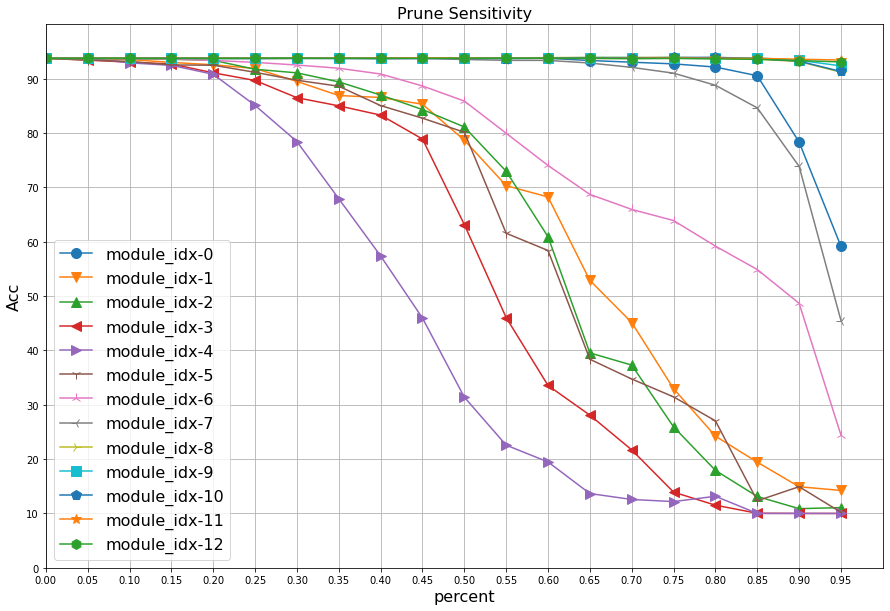

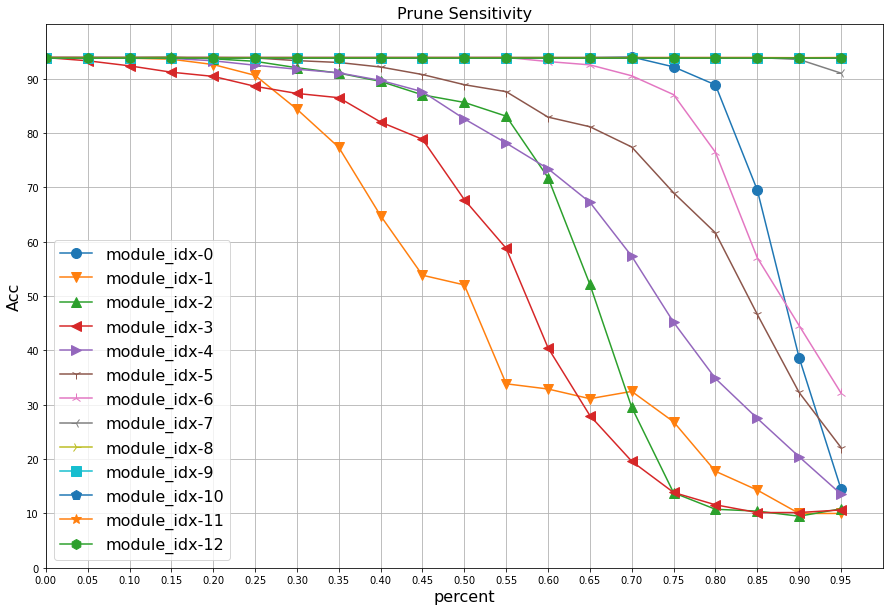

In [5]:
    import matplotlib.pyplot as plt
    from copy import deepcopy
    
    def plt_sensitivity(sen, percent_list):
        marker_list = [ 'o',       # circle marker  
                        'v',       # triangle_down marker  
                        '^',       # triangle_up marker  
                        '<',       # triangle_left marker  
                        '>',       # triangle_right marker  
                        '1',       # tri_down marker  
                        '2',       # tri_up marker  
                        '3',       # tri_left marker  
                        '4',       # tri_right marker  
                        's',       # square marker  
                        'p',       # pentagon marker  
                        '*',       # star marker  
                        'h',       # hexagon1 marker  
                        'H',       # hexagon2 marker  
                        '+',       # plus marker  
                        'x',       # x marker  
                        'D',       # diamond marker  
                        'd',       # thin_diamond marker  
                        '|',       # vline marker  
                        '_',        # hline marker 
                        '.',       # point marker
                        ','       # pixel marker
                      ]

        x = percent_list

        figure, ax = plt.subplots(figsize=(15,10))

        plt.xlim(0.,1.) # 设置x轴的刻度
        plt.ylim(0.,100.) # 设置y轴的刻度
        plt.xticks(x) # x轴上显示哪些文字
        plt.yticks([x for x in range(0,100,10)]) # y轴上显示哪些文字

        y_list = []
        y = []
        for i,s in enumerate(sen):
            y.append(s[3])

            if i%(len(x)) == (len(x)-1):
                y_list.append(deepcopy(y))
                y.clear()

        for i,y in enumerate(y_list):
            label = "module_idx-" + str(i)
            marker = marker_list[i%len(y_list)]

            # label表示将要显示在图例中的文字
            # marker表示折现上每个点的图形形状
            # ms表示每个点的大小
            plt.plot(x,y,label=label,marker=marker,ms=10) 

        plt.tick_params(labelsize=10) # 坐标轴的字体大小

        font1 = { 'family' : 'Times New Roman',
                'weight' : 'normal',
                'size'   : 16,
            }
        plt.legend(prop=font1) # 设置图例

        plt.xlabel('percent', font1) # X轴标题
        plt.ylabel('Acc', font1) # Y轴标题
        plt.title('Prune Sensitivity', font1) # 图标题

        plt.grid() # 图中显示表格

        # img_file=os.path.join(opt.saved_dir, "%s_sensitivity.svg"%opt.model_name)
        # plt.savefig(fname=img_file,format="svg")
        plt.show()
        
    plt_sensitivity(l1_norm_sen, percent_list)
    plt_sensitivity(ns_sen, percent_list)

In [6]:
    # 根据剪枝敏感性分析确定每一层的剪枝率,每一层的剪枝率要保证不会使得精度下降超过threshold
    def layer_percent(sen, percent_list, threshold = 0.1): 
        x = percent_list
        
        y_list = []
        y = []
        for i,s in enumerate(sen):
            y.append(s[3])

            if i%(len(x)) == (len(x)-1):
                y_list.append(deepcopy(y))
                y.clear()
                
        r = []
        for y in y_list:
            r.append(x[0])
            not_prune_acc = y[0]
            for i,acc in enumerate(y[1:]):
                if (not_prune_acc - acc) < threshold:
                    r[-1] = x[i+1]
                else:
                    break
        return r
    
    
    l1_norm_layer_percent = layer_percent(l1_norm_sen, percent_list)
    ns_layer_percent = layer_percent(ns_sen, percent_list)
    
    print("l1_norm_layer_percent:\t", l1_norm_layer_percent)
    print("ns_layer_percent:\t", ns_layer_percent)

l1_norm_layer_percent:	 [0.6, 0.05, 0.1, 0.0, 0.05, 0.0, 0.1, 0.45, 0.8, 0.85, 0.85, 0.85, 0.75]
ns_layer_percent:	 [0.7, 0.05, 0.15, 0.0, 0.1, 0.25, 0.55, 0.85, 0.95, 0.95, 0.95, 0.95, 0.95]


In [7]:
    # 伪剪枝
    
    def pseudo_prune(model, layer_percent, mode):
        masked_model = deepcopy(model)

        origin_module_list = model.get_module_list()
        masked_module_list = masked_model.get_module_list()
        
        cfg_remain = []
        cfg_mask = []
        total_remain = 0
        total_pruned = 0

        for m_idx,m in enumerate(masked_module_list):
            percent = layer_percent[m_idx]
            
            num_filter = m['bn'].weight.data.shape[0]

            # 当前卷积模块最少要保留的输出通道数目
            min_channel_num = int(num_filter*opt.layer_keep) if int(num_filter * opt.layer_keep) > 0 else 1

            if mode == 'random':
                mask = [1. if idx < min(int(num_filter*percent), min_channel_num) else 0. \
                        for idx in range(num_filter)]
                mask = shuffle(mask)

                mask = torch.tensor(mask).to(device)
            elif mode == 'ns':
                bn = m['bn'].weight.data.abs().clone()

                y,i = torch.sort(bn)
                thre_index = int(num_filter*percent)
                thre = y[thre_index]

                mask = m['bn'].weight.data.abs().ge(thre)

                # 当剪枝后输出通道数目小于当前卷积模块最少要保留的输出通道数目
                if int(torch.sum(mask)) < min_channel_num: 
                    _, sorted_index_weights = torch.sort(weight_copy,descending=True)
                    mask[sorted_index_weights[:min_channel_num]]=1.
            elif mode == 'l1_norm':
                conv = torch.sum(m['conv'].weight.data.abs().clone(),(1,2,3))
                y,i = torch.sort(conv.clone())
                thre_index = int(num_filter*percent)
                thre = y[thre_index]

                mask = conv.ge(thre)

                # 当剪枝后输出通道数目小于当前卷积模块最少要保留的输出通道数目
                if int(torch.sum(mask)) < min_channel_num: 
                    _, sorted_index_weights = torch.sort(conv,descending=True)
                    mask[sorted_index_weights[:min_channel_num]]=1.

            cfg_mask.append(mask.clone())
            
            if mode == "l1_norm":
                for i,t in enumerate(mask):
                    if t == 0.:
                        m['conv'].weight.data[i].copy_(torch.zeros(m['conv'].weight.data[i].size()))
            else:
                m['bn'].weight.data.mul_(mask)
                m['bn'].bias.data.mul_(mask)

            remain = int(torch.sum(mask))
            cfg_remain.append(remain)
            
            pruned = num_filter - remain
            real_percent = pruned/num_filter
            
            total_remain += remain
            total_pruned += pruned

            print('module_idx:%3g \t percent:%3g \t remain:%4g \t pruned:%4g \t real_percent:%4g'%(m_idx, percent, remain, pruned, real_percent))

        print("total_remain:%4g \t total_pruned:%4g \t real_percent:%4g"%(total_remain, total_pruned, total_pruned/(total_remain+total_pruned)))
        metric = eval_model(masked_model)
        
        return cfg_remain, cfg_mask
        
        
    l1_norm_cfg_remain, l1_norm_cfg_mask = pseudo_prune(baseline_model, l1_norm_layer_percent, 'l1_norm')
    ns_cfg_remain, ns_cfg_mask = pseudo_prune(sp_model, ns_layer_percent, 'ns')

module_idx:  0 	 percent:0.6 	 remain:  26 	 pruned:  38 	 real_percent:0.59375
module_idx:  1 	 percent:0.05 	 remain:  61 	 pruned:   3 	 real_percent:0.046875
module_idx:  2 	 percent:0.1 	 remain: 116 	 pruned:  12 	 real_percent:0.09375
module_idx:  3 	 percent:  0 	 remain: 128 	 pruned:   0 	 real_percent:   0
module_idx:  4 	 percent:0.05 	 remain: 244 	 pruned:  12 	 real_percent:0.046875
module_idx:  5 	 percent:  0 	 remain: 256 	 pruned:   0 	 real_percent:   0
module_idx:  6 	 percent:0.1 	 remain: 231 	 pruned:  25 	 real_percent:0.0976562
module_idx:  7 	 percent:0.45 	 remain: 282 	 pruned: 230 	 real_percent:0.449219
module_idx:  8 	 percent:0.8 	 remain: 103 	 pruned: 409 	 real_percent:0.798828
module_idx:  9 	 percent:0.85 	 remain:  77 	 pruned: 435 	 real_percent:0.849609
module_idx: 10 	 percent:0.85 	 remain:  77 	 pruned: 435 	 real_percent:0.849609
module_idx: 11 	 percent:0.85 	 remain:  77 	 pruned: 435 	 real_percent:0.849609
module_idx: 12 	 percent:0.75 	

      1.62   4.1e+03     1e+04        41: 100%|██████████| 79/79 [00:01<00:00, 72.71it/s]


module_idx:  0 	 percent:0.7 	 remain:  20 	 pruned:  44 	 real_percent:0.6875
module_idx:  1 	 percent:0.05 	 remain:  61 	 pruned:   3 	 real_percent:0.046875
module_idx:  2 	 percent:0.15 	 remain: 109 	 pruned:  19 	 real_percent:0.148438
module_idx:  3 	 percent:  0 	 remain: 128 	 pruned:   0 	 real_percent:   0
module_idx:  4 	 percent:0.1 	 remain: 231 	 pruned:  25 	 real_percent:0.0976562
module_idx:  5 	 percent:0.25 	 remain: 192 	 pruned:  64 	 real_percent:0.25
module_idx:  6 	 percent:0.55 	 remain: 116 	 pruned: 140 	 real_percent:0.546875
module_idx:  7 	 percent:0.85 	 remain:  77 	 pruned: 435 	 real_percent:0.849609
module_idx:  8 	 percent:0.95 	 remain:  26 	 pruned: 486 	 real_percent:0.949219
module_idx:  9 	 percent:0.95 	 remain:  26 	 pruned: 486 	 real_percent:0.949219
module_idx: 10 	 percent:0.95 	 remain:  26 	 pruned: 486 	 real_percent:0.949219
module_idx: 11 	 percent:0.95 	 remain:  26 	 pruned: 486 	 real_percent:0.949219
module_idx: 12 	 percent:0.9

     0.288  9.35e+03     1e+04      93.5: 100%|██████████| 79/79 [00:01<00:00, 73.13it/s]


In [8]:
    # 真正的剪枝
    def real_prune(origin_model, cfg_remain, cfg_mask):
        vgg_cfg = VGGCFG()
        pruned_model_cfg = vgg_cfg.convert_list_to_cfg(origin_model, cfg_remain) # 剪枝后模型的cfg
        print(pruned_model_cfg)
        pruned_model = globals()[opt.model_name](pruned_model_cfg) # 通过cfg生成剪枝后的模型

        pruned_model = pruned_model.to(device)

        origin_module_list = origin_model.get_module_list() # 原始模型的module_list
        pruned_module_list = pruned_model.get_module_list() # 剪枝后的模型的module_list

        # 从origin_model中拷贝参数到pruned_model
        for i,(m,p_m) in enumerate(zip(origin_module_list,pruned_module_list)):
            conv = m['conv']
            bn = m['bn']
            p_conv = p_m['conv']
            p_bn = p_m['bn']
            
            in_channel_idx = [] # 当前层剩余的输入通道(上一层的输出通道)，即剩余的filter的深度idx,即掩码为1的深度idx
            if i == 0: # 第0个卷积前面没有层了，需要特殊考虑
                for j in range(conv.weight.data.shape[1]):
                    in_channel_idx.append(j)
            else:
                for j in range(len(cfg_mask[i-1])):
                    if cfg_mask[i-1][j]:
                        in_channel_idx.append(j)

            out_channel_idx = [] # 当前层剩余的输出通道，即剩余的filter的idx,即掩码为1的filter的idx
            for j in range(len(cfg_mask[i])):
                if cfg_mask[i][j]:
                    out_channel_idx.append(j)

            # 对BN层的参数赋值
            p_bn.weight.data.copy_(bn.weight.data[out_channel_idx])
            p_bn.bias.data.copy_(bn.bias.data[out_channel_idx])
            p_bn.running_mean.data.copy_(bn.running_mean.data[out_channel_idx])
            p_bn.running_var.data.copy_(bn.running_var.data[out_channel_idx])

            # 对卷积层的参数赋值
            tmp = conv.weight.data[:,in_channel_idx,:,:]
            p_conv.weight.data.copy_(tmp[out_channel_idx,:,:,:])
            # very important!!!
            if not (conv.bias is None):
                p_conv.bias.data.copy_(conv.bias.data[out_channel_idx])
            
        # 全连接层的参数赋值
        collum_idx = [] # 上一个卷积层剩余的filter数目等于当前全连接层权重矩阵的列数
        for j in range(len(cfg_mask[-1])):
            if cfg_mask[-1][j]:
                collum_idx.append(j)
        pruned_model.classifier.weight.data.copy_(origin_model.classifier.weight.data[:,collum_idx])
        pruned_model.classifier.bias.data.copy_(origin_model.classifier.bias.data)

        print("\nlet's test the pruned_model:")
        eval_model(pruned_model) # 测试pruned_model
        
        return pruned_model
        
    l1_norm_pruned_model = real_prune(baseline_model, l1_norm_cfg_remain, l1_norm_cfg_mask)
    ns_pruned_model = real_prune(sp_model, ns_cfg_remain, ns_cfg_mask)

[26, 61, 'M', 116, 128, 'M', 244, 256, 231, 'M', 282, 103, 77, 'M', 77, 77, 128, 'M']

let's test the pruned_model:

 test_loss   correct     total       Acc


      1.67  6.32e+03     1e+04      63.2: 100%|██████████| 79/79 [00:00<00:00, 89.59it/s]


[20, 61, 'M', 109, 128, 'M', 231, 192, 116, 'M', 77, 26, 26, 'M', 26, 26, 26, 'M']

let's test the pruned_model:

 test_loss   correct     total       Acc


     0.288  9.35e+03     1e+04      93.5: 100%|██████████| 79/79 [00:00<00:00, 92.91it/s]


In [9]:
    # 保存剪枝后的模型
    
    if not os.path.isdir(opt.saved_dir):
        os.mkdir(opt.saved_dir)
    
    def save_model(pruned_model, mode):
        cfg_saved_path = "pruned_%s_%s.cfg"%(mode, opt.model_name)
        weights_saved_path = "pruned_%s_%s.pth"%(mode, opt.model_name)

        cfg_saved_path = os.path.join(opt.saved_dir, cfg_saved_path)
        weights_saved_path = os.path.join(opt.saved_dir, weights_saved_path)

        cfg_state = {
            'cfg': pruned_model.cfg
        }

        weights_state = {
            'model': pruned_model.state_dict()
        }

        torch.save(cfg_state, cfg_saved_path)
        torch.save(weights_state, weights_saved_path)

        print(f"pruned_model's cfg has been saved: {cfg_saved_path}")
        print(f"pruned_model's weights has been saved: {weights_saved_path}")
        
    save_model(l1_norm_pruned_model, 'l1_norm')
    save_model(ns_pruned_model, 'ns')

pruned_model's cfg has been saved: exp_VGG16/l1-norm_ns_random/pruned_l1_norm_VGG16.cfg
pruned_model's weights has been saved: exp_VGG16/l1-norm_ns_random/pruned_l1_norm_VGG16.pth
pruned_model's cfg has been saved: exp_VGG16/l1-norm_ns_random/pruned_ns_VGG16.cfg
pruned_model's weights has been saved: exp_VGG16/l1-norm_ns_random/pruned_ns_VGG16.pth


In [10]:
!mkdir -p exp_VGG16/l1-norm_ns_random/finetune/l1_norm
# l1_norm finetune
!python train.py --model-name VGG16 --cfg exp_VGG16/l1-norm_ns_random/pruned_l1_norm_VGG16.cfg \
    -ckpt exp_VGG16/l1-norm_ns_random/pruned_l1_norm_VGG16.pth \
    -ckpt-dir exp_VGG16/l1-norm_ns_random/finetune/l1_norm -log exp_VGG16/l1-norm_ns_random/finetune/l1_norm \
    --lr 0.01 --epochs 100

Namespace(batch_size=128, cfg='exp_VGG16/l1-norm_ns_random/pruned_l1_norm_VGG16.cfg', checkpoint='exp_VGG16/l1-norm_ns_random/pruned_l1_norm_VGG16.pth', checkpoint_dir='exp_VGG16/l1-norm_ns_random/finetune/l1_norm', device='', epochs=100, from_scratch=False, logdir='exp_VGG16/l1-norm_ns_random/finetune/l1_norm', lr=0.01, model_name='VGG16', nosave=False, prune=0, resume=False, s=0.001, sr=False)
Start Tensorboard with "tensorboard --logdir=exp_VGG16/l1-norm_ns_random/finetune/l1_norm, view at http://localhost:6006/
Using CUDA device0 _CudaDeviceProperties(name='GeForce RTX 2080 Ti', total_memory=11019MB)
           device1 _CudaDeviceProperties(name='GeForce RTX 2080 Ti', total_memory=11019MB)

Files already downloaded and verified
Files already downloaded and verified
lr: 0.01

     Epoch   gpu_mem      Loss   correct     total       Acc
      0/99     1.13G     0.103  4.84e+04     5e+04      96.8: 100%|█| 391/391 [0

 test_loss   correct     total       Acc
     0.411  8.82e+03     1

     0.364  9.06e+03     1e+04      90.7: 100%|█| 79/79 [00:00<00:00, 96.90it/s]
lr: 0.01

     Epoch   gpu_mem      Loss   correct     total       Acc
     27/99     1.13G    0.0668  4.89e+04     5e+04      97.7: 100%|█| 391/391 [0

 test_loss   correct     total       Acc
     0.316  9.11e+03     1e+04      91.1: 100%|█| 79/79 [00:00<00:00, 97.51it/s]
lr: 0.01

     Epoch   gpu_mem      Loss   correct     total       Acc
     28/99     1.13G    0.0615   4.9e+04     5e+04      97.9: 100%|█| 391/391 [0

 test_loss   correct     total       Acc
     0.349  9.02e+03     1e+04      90.2: 100%|█| 79/79 [00:00<00:00, 97.66it/s]
lr: 0.01

     Epoch   gpu_mem      Loss   correct     total       Acc
     29/99     1.13G    0.0611   4.9e+04     5e+04        98: 100%|█| 391/391 [0

 test_loss   correct     total       Acc
     0.345  9.15e+03     1e+04      91.5: 100%|█| 79/79 [00:00<00:00, 100.63it/s
lr: 0.01

     Epoch   gpu_mem      Loss   correct     total       Acc
     30/99     1.13G   

     56/99     1.13G   0.00728  4.99e+04     5e+04      99.8: 100%|█| 391/391 [0

 test_loss   correct     total       Acc
     0.271  9.34e+03     1e+04      93.4: 100%|█| 79/79 [00:00<00:00, 95.88it/s]
lr: 0.001

     Epoch   gpu_mem      Loss   correct     total       Acc
     57/99     1.13G   0.00651  4.99e+04     5e+04      99.8: 100%|█| 391/391 [0

 test_loss   correct     total       Acc
     0.274  9.35e+03     1e+04      93.5: 100%|█| 79/79 [00:00<00:00, 96.97it/s]
lr: 0.001

     Epoch   gpu_mem      Loss   correct     total       Acc
     58/99     1.13G   0.00539  4.99e+04     5e+04      99.9: 100%|█| 391/391 [0

 test_loss   correct     total       Acc
     0.274  9.35e+03     1e+04      93.5: 100%|█| 79/79 [00:00<00:00, 97.15it/s]
lr: 0.001

     Epoch   gpu_mem      Loss   correct     total       Acc
     59/99     1.13G   0.00512  4.99e+04     5e+04      99.9: 100%|█| 391/391 [0

 test_loss   correct     total       Acc
     0.278  9.35e+03     1e+04      93.5: 100%|█|

     85/99     1.13G   0.00231     5e+04     5e+04       100: 100%|█| 391/391 [0

 test_loss   correct     total       Acc
     0.281  9.38e+03     1e+04      93.8: 100%|█| 79/79 [00:00<00:00, 100.93it/s
lr: 0.00010000000000000002

     Epoch   gpu_mem      Loss   correct     total       Acc
     86/99     1.13G   0.00271     5e+04     5e+04      99.9: 100%|█| 391/391 [0

 test_loss   correct     total       Acc
     0.281  9.38e+03     1e+04      93.8: 100%|█| 79/79 [00:00<00:00, 98.88it/s]
lr: 0.00010000000000000002

     Epoch   gpu_mem      Loss   correct     total       Acc
     87/99     1.13G   0.00245     5e+04     5e+04       100: 100%|█| 391/391 [0

 test_loss   correct     total       Acc
     0.281  9.38e+03     1e+04      93.8: 100%|█| 79/79 [00:00<00:00, 98.09it/s]
lr: 0.00010000000000000002

     Epoch   gpu_mem      Loss   correct     total       Acc
     88/99     1.13G    0.0023     5e+04     5e+04       100: 100%|█| 391/391 [0

 test_loss   correct     total       Ac

In [11]:
!mkdir -p exp_VGG16/l1-norm_ns_random/finetune/ns
# ns finetune
!python train.py --model-name VGG16 --cfg exp_VGG16/l1-norm_ns_random/pruned_ns_VGG16.cfg \
    -ckpt exp_VGG16/l1-norm_ns_random/pruned_ns_VGG16.pth \
    -ckpt-dir exp_VGG16/l1-norm_ns_random/finetune/ns -log exp_VGG16/l1-norm_ns_random/finetune/ns \
    --lr 0.01 --epochs 100

Namespace(batch_size=128, cfg='exp_VGG16/l1-norm_ns_random/pruned_ns_VGG16.cfg', checkpoint='exp_VGG16/l1-norm_ns_random/pruned_ns_VGG16.pth', checkpoint_dir='exp_VGG16/l1-norm_ns_random/finetune/ns', device='', epochs=100, from_scratch=False, logdir='exp_VGG16/l1-norm_ns_random/finetune/ns', lr=0.01, model_name='VGG16', nosave=False, prune=0, resume=False, s=0.001, sr=False)
Start Tensorboard with "tensorboard --logdir=exp_VGG16/l1-norm_ns_random/finetune/ns, view at http://localhost:6006/
Using CUDA device0 _CudaDeviceProperties(name='GeForce RTX 2080 Ti', total_memory=11019MB)
           device1 _CudaDeviceProperties(name='GeForce RTX 2080 Ti', total_memory=11019MB)

Files already downloaded and verified
Files already downloaded and verified
lr: 0.01

     Epoch   gpu_mem      Loss   correct     total       Acc
      0/99    0.984G     0.372  4.38e+04     5e+04      87.7: 100%|█| 391/391 [0

 test_loss   correct     total       Acc
     0.704  7.95e+03     1e+04      79.5: 100%|█| 7

     27/99    0.984G    0.0912  4.85e+04     5e+04        97: 100%|█| 391/391 [0

 test_loss   correct     total       Acc
     0.367  8.97e+03     1e+04      89.7: 100%|█| 79/79 [00:00<00:00, 101.09it/s
lr: 0.01

     Epoch   gpu_mem      Loss   correct     total       Acc
     28/99    0.984G     0.095  4.84e+04     5e+04      96.8: 100%|█| 391/391 [0

 test_loss   correct     total       Acc
     0.339  9.05e+03     1e+04      90.5: 100%|█| 79/79 [00:00<00:00, 102.05it/s
lr: 0.01

     Epoch   gpu_mem      Loss   correct     total       Acc
     29/99    0.984G    0.0877  4.85e+04     5e+04      97.1: 100%|█| 391/391 [0

 test_loss   correct     total       Acc
     0.377  8.94e+03     1e+04      89.4: 100%|█| 79/79 [00:00<00:00, 101.48it/s
lr: 0.01

     Epoch   gpu_mem      Loss   correct     total       Acc
     30/99    0.984G     0.091  4.84e+04     5e+04      96.9: 100%|█| 391/391 [0

 test_loss   correct     total       Acc
     0.342  8.99e+03     1e+04      89.9: 100%|█| 79

     57/99    0.984G    0.0124  4.98e+04     5e+04      99.6: 100%|█| 391/391 [0

 test_loss   correct     total       Acc
     0.261  9.33e+03     1e+04      93.3: 100%|█| 79/79 [00:00<00:00, 102.58it/s
lr: 0.001

     Epoch   gpu_mem      Loss   correct     total       Acc
     58/99    0.984G    0.0125  4.98e+04     5e+04      99.6: 100%|█| 391/391 [0

 test_loss   correct     total       Acc
     0.261  9.36e+03     1e+04      93.5: 100%|█| 79/79 [00:00<00:00, 107.09it/s
lr: 0.001

     Epoch   gpu_mem      Loss   correct     total       Acc
     59/99    0.984G    0.0113  4.98e+04     5e+04      99.7: 100%|█| 391/391 [0

 test_loss   correct     total       Acc
     0.265  9.34e+03     1e+04      93.4: 100%|█| 79/79 [00:00<00:00, 102.09it/s
lr: 0.001

     Epoch   gpu_mem      Loss   correct     total       Acc
     60/99    0.984G    0.0109  4.98e+04     5e+04      99.7: 100%|█| 391/391 [0

 test_loss   correct     total       Acc
     0.265  9.34e+03     1e+04      93.4: 100%|█|

     86/99    0.984G   0.00519  4.99e+04     5e+04      99.9: 100%|█| 391/391 [0

 test_loss   correct     total       Acc
      0.28  9.36e+03     1e+04      93.6: 100%|█| 79/79 [00:00<00:00, 100.13it/s
lr: 0.00010000000000000002

     Epoch   gpu_mem      Loss   correct     total       Acc
     87/99    0.984G   0.00538  4.99e+04     5e+04      99.8: 100%|█| 391/391 [0

 test_loss   correct     total       Acc
     0.281  9.36e+03     1e+04      93.6: 100%|█| 79/79 [00:00<00:00, 102.79it/s
lr: 0.00010000000000000002

     Epoch   gpu_mem      Loss   correct     total       Acc
     88/99    0.984G   0.00527  4.99e+04     5e+04      99.9: 100%|█| 391/391 [0

 test_loss   correct     total       Acc
     0.279  9.36e+03     1e+04      93.6: 100%|█| 79/79 [00:00<00:00, 108.56it/s
lr: 0.00010000000000000002

     Epoch   gpu_mem      Loss   correct     total       Acc
     89/99    0.984G   0.00503  4.99e+04     5e+04      99.9: 100%|█| 391/391 [0

 test_loss   correct     total       Ac